In [172]:
library(tidyverse)
library(ggplot2)
library(dplyr)
library(base)
library(forcats)
#install.packages("janitor")
library(janitor)

In [2]:
getwd()

[1] "/Users/jinghan/Desktop/fifa/fifa22-ultimate-team-recommender/data/processed"

In [2]:
options(repr.plot.width=30, repr.plot.height=15)

In [3]:
setwd('/Users/jinghan/Desktop/fifa/fifa22-ultimate-team-recommender/data/raw')

In [4]:
raw <- read_csv("raw.csv")

Rows: 13937 Columns: 42

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): name, country, club, best_position
dbl (38): age, overall, potential, value (K), wage (ERO), Crossing, Finishin...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [33]:
head(raw)

name             country   age overall potential club                     
1 Greg Halford     England   36  59      59        Waterford FC             
2 Santiago Silva   Uruguay   40  71      71        Club Atlético Aldosivi   
3 Sammy Bossut     Belgium   35  69      69        SV Zulte Waregem         
4 Marcelo Barovero Argentina 37  70      70        Club Atlético de San Luis
5 Enrique Bologna  Argentina 39  72      72        Club Atlético Banfield   
6 Santiago Salcedo Paraguay  39  66      66        General Caballero (JLM)  
  pos value (K) wage Crossing ⋯ Vision Penalties Composure Defensive Awareness
1 CB   40        500 53       ⋯ 52     61        61        59                 
2 ST    0       7000 52       ⋯ 68     74        76        37                 
3 GK  150       4000 12       ⋯ 49     17        47        22                 
4 GK  180       5000 14       ⋯ 51     20        64        19                 
5 GK  250       5000 21       ⋯ 53     25        65        12                 
6 ST  300        500 59       ⋯ 60     79        59        14                 
  Standing Tackle Sliding Tackle Diving Handling Kicking Reflexes
1 61              59             12     16       11      14      
2 39              34             13     11       13      15      
3 14              13             67     70       63      68      
4 16              14             68     66       63      71      
5 22              17             74     67       72      74      
6 36              34             12     13       14      15

# 1. Wage vs Best Position

In [176]:
# raw <- raw %>%
# rename(#"pos" = "best_position", 
#    # "wage" = "wage (ERO)",
#     #"value_K" = "value (K)",)
raw <- clean_names(raw)
head(raw)

name             country   age overall potential club                     
1 Greg Halford     England   36  59      59        Waterford FC             
2 Santiago Silva   Uruguay   40  71      71        Club Atlético Aldosivi   
3 Sammy Bossut     Belgium   35  69      69        SV Zulte Waregem         
4 Marcelo Barovero Argentina 37  70      70        Club Atlético de San Luis
5 Enrique Bologna  Argentina 39  72      72        Club Atlético Banfield   
6 Santiago Salcedo Paraguay  39  66      66        General Caballero (JLM)  
  pos value_k wage crossing ⋯ vision penalties composure defensive_awareness
1 CB   40      500 53       ⋯ 52     61        61        59                 
2 ST    0     7000 52       ⋯ 68     74        76        37                 
3 GK  150     4000 12       ⋯ 49     17        47        22                 
4 GK  180     5000 14       ⋯ 51     20        64        19                 
5 GK  250     5000 21       ⋯ 53     25        65        12                 
6 ST  300      500 59       ⋯ 60     79        59        14                 
  standing_tackle sliding_tackle diving handling kicking reflexes
1 61              59             12     16       11      14      
2 39              34             13     11       13      15      
3 14              13             67     70       63      68      
4 16              14             68     66       63      71      
5 22              17             74     67       72      74      
6 36              34             12     13       14      15

In [177]:
pos_vs_wage <- raw%>%
select(pos, wage)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    500    1000    7000   25577   29250  450000 

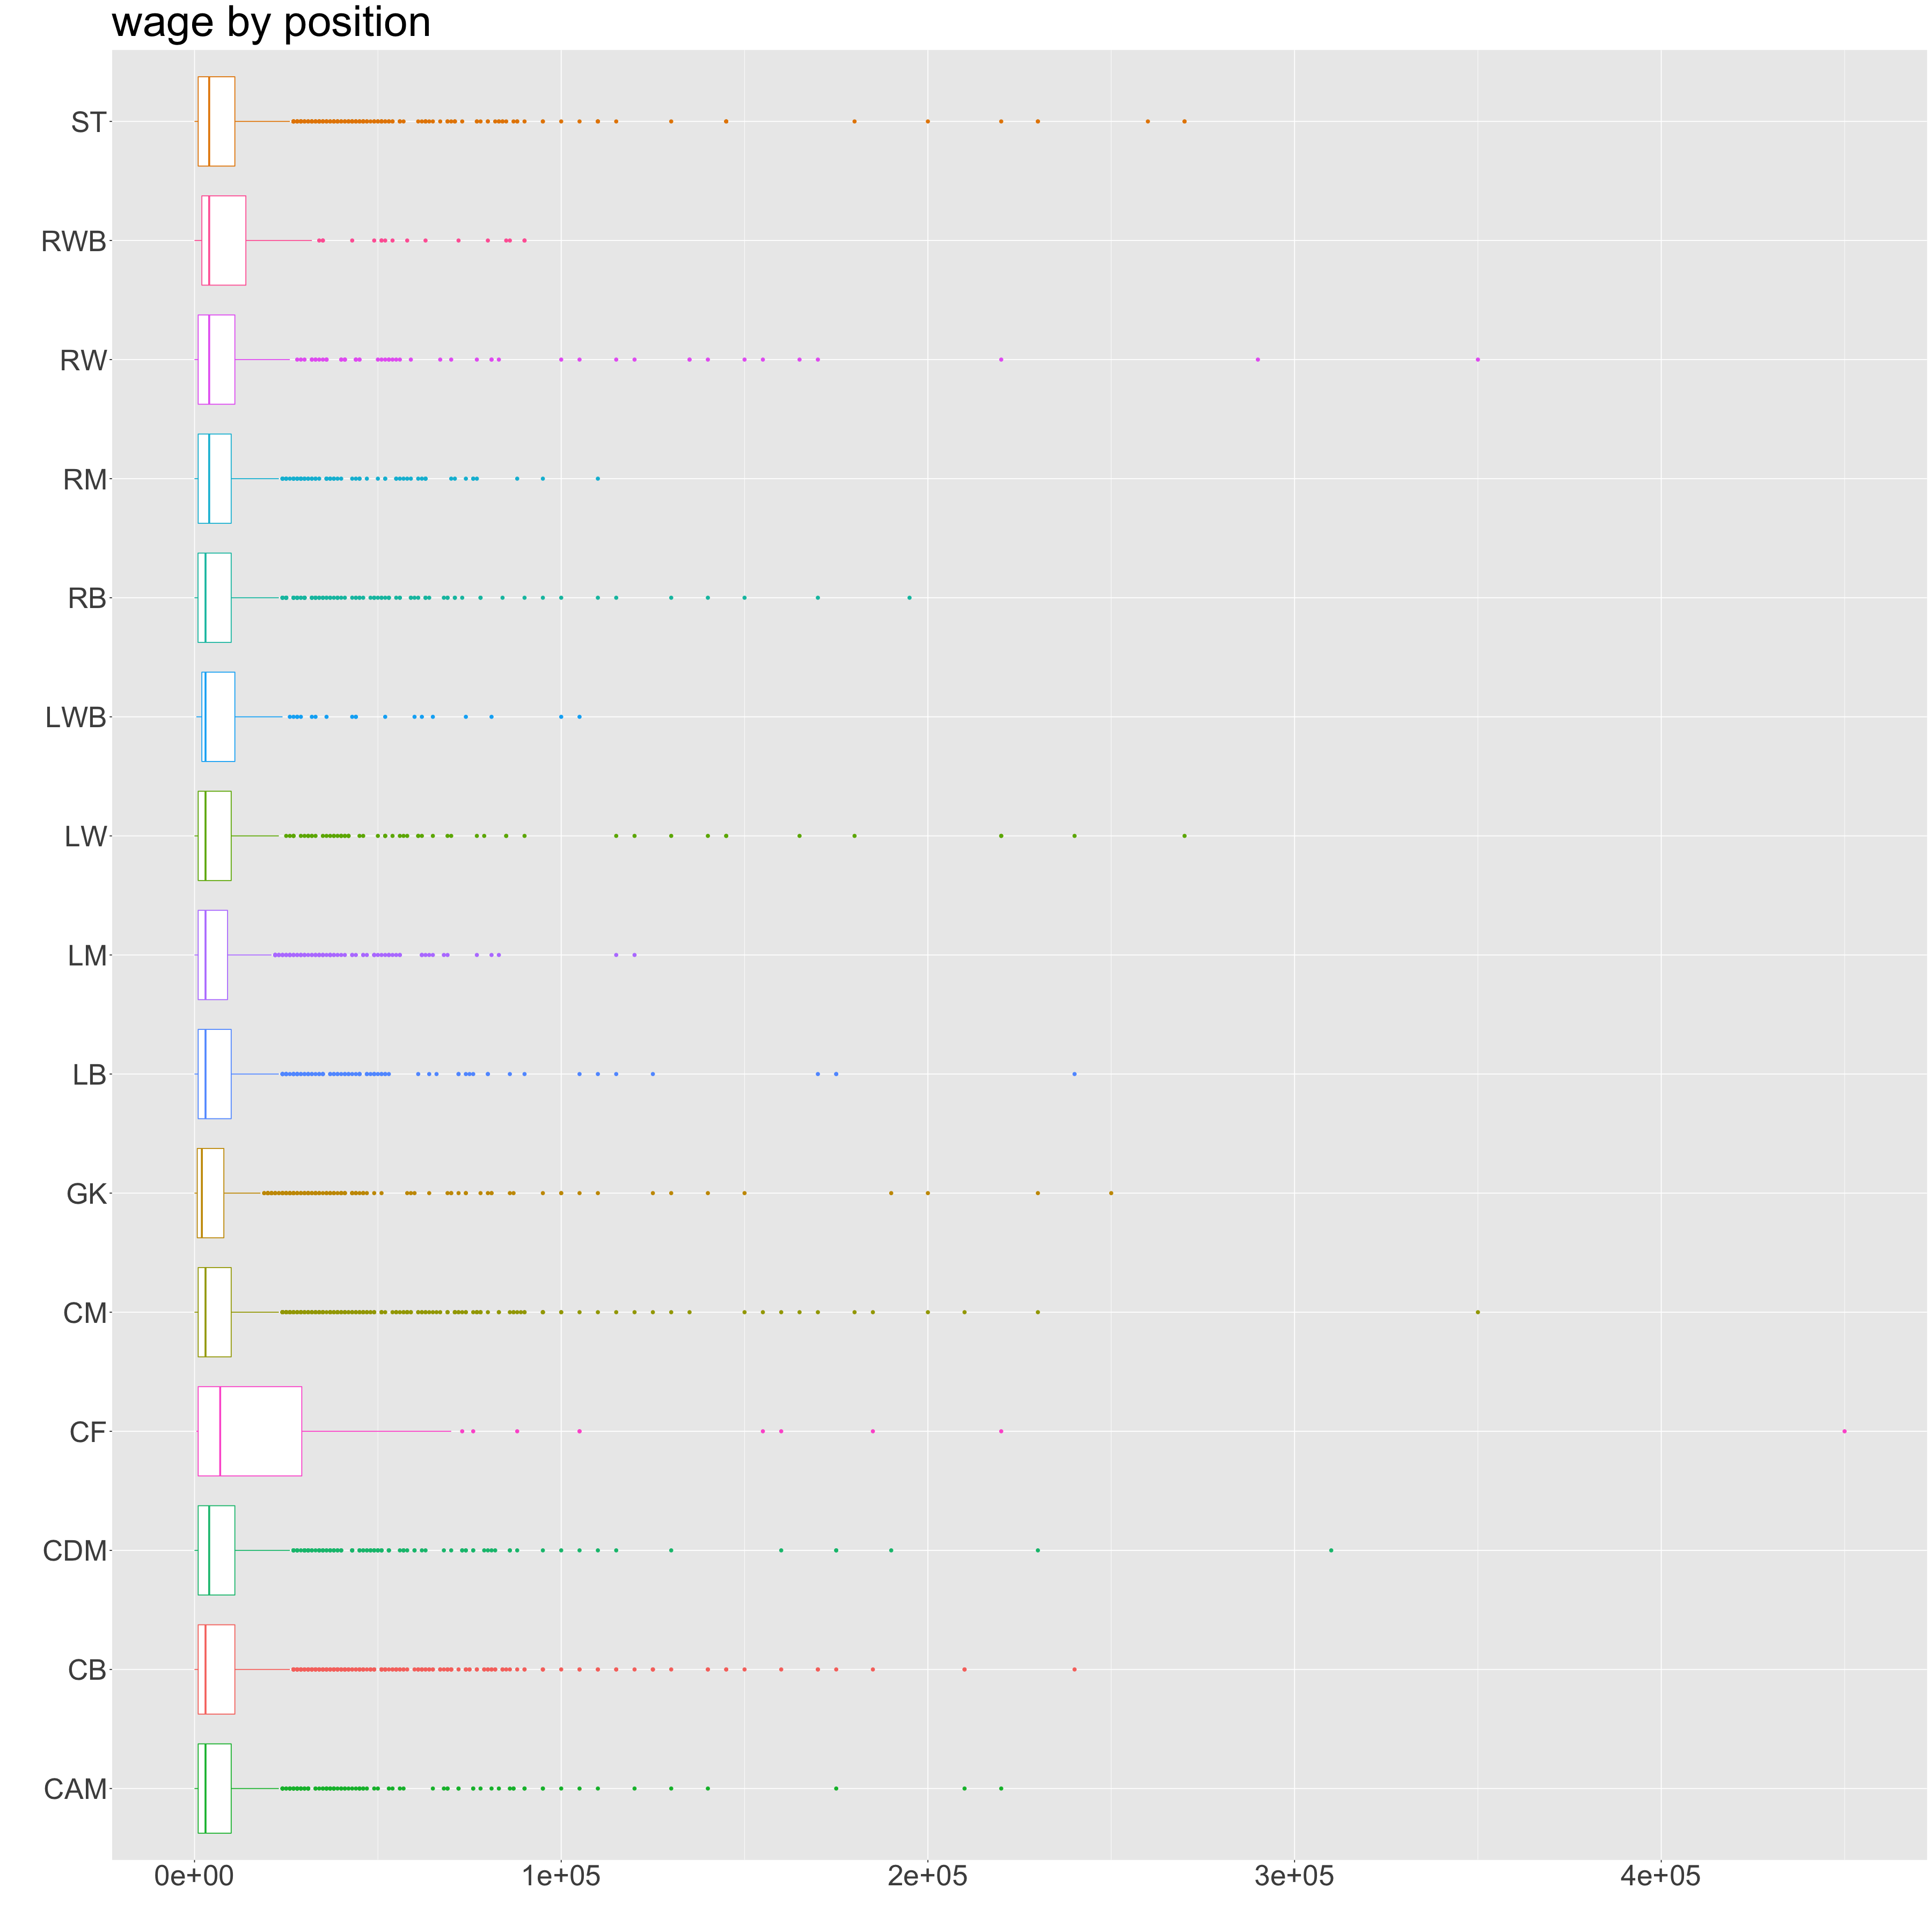

In [297]:
pos_vs_wage %>%
ggplot(aes(x = pos, y = wage, color = as_factor(pos))) +
geom_boxplot() +
# facet_grid(rows = vars(pos))+
theme(text = element_text(size = 40), legend.position="none") +
labs(x = "", y = "", title = "wage by position")+

coord_flip()


**there are many outliers for all the positioins which show the distribution of wage is extremtly uneven. Especially those star players are enjoying many times wage as other players.** 

**most players in all positions having the wage ranging from 50% to 75% quantile only have less than 300 ero / month.**

**wage for CF players is outstandingly higher than wage for players in other postiosn and a large proportuion of CF players earn more than the mean wage**

**given that many outliers we are thinking that we shouldn't just treat them as no-sense value. Instead, it's worth exploring the pattern of such ourliers.**

In [179]:
pos_vs_wage_outlier <- pos_vs_wage %>%
group_by(pos)%>%
summarise(upper = quantile(wage, 0,75) + 1.5 * IQR(wage), count = mean(wage > upper)*n())%>%
arrange(desc(upper))
pos_vs_wage_outlier

pos upper count
1  CF  42875  21  
2  RWB 18000  35  
3  CB  15000 433  
4  CDM 15000 217  
5  RW  15000  77  
6  ST  15000 362  
7  LWB 14000  39  
8  RB  13575 175  
9  CAM 13500 173  
10 CM  13500 358  
11 LB  13500 160  
12 LW  13500  84  
13 RM  13500 140  
14 LM  12000 155  
15 GK  10875 256

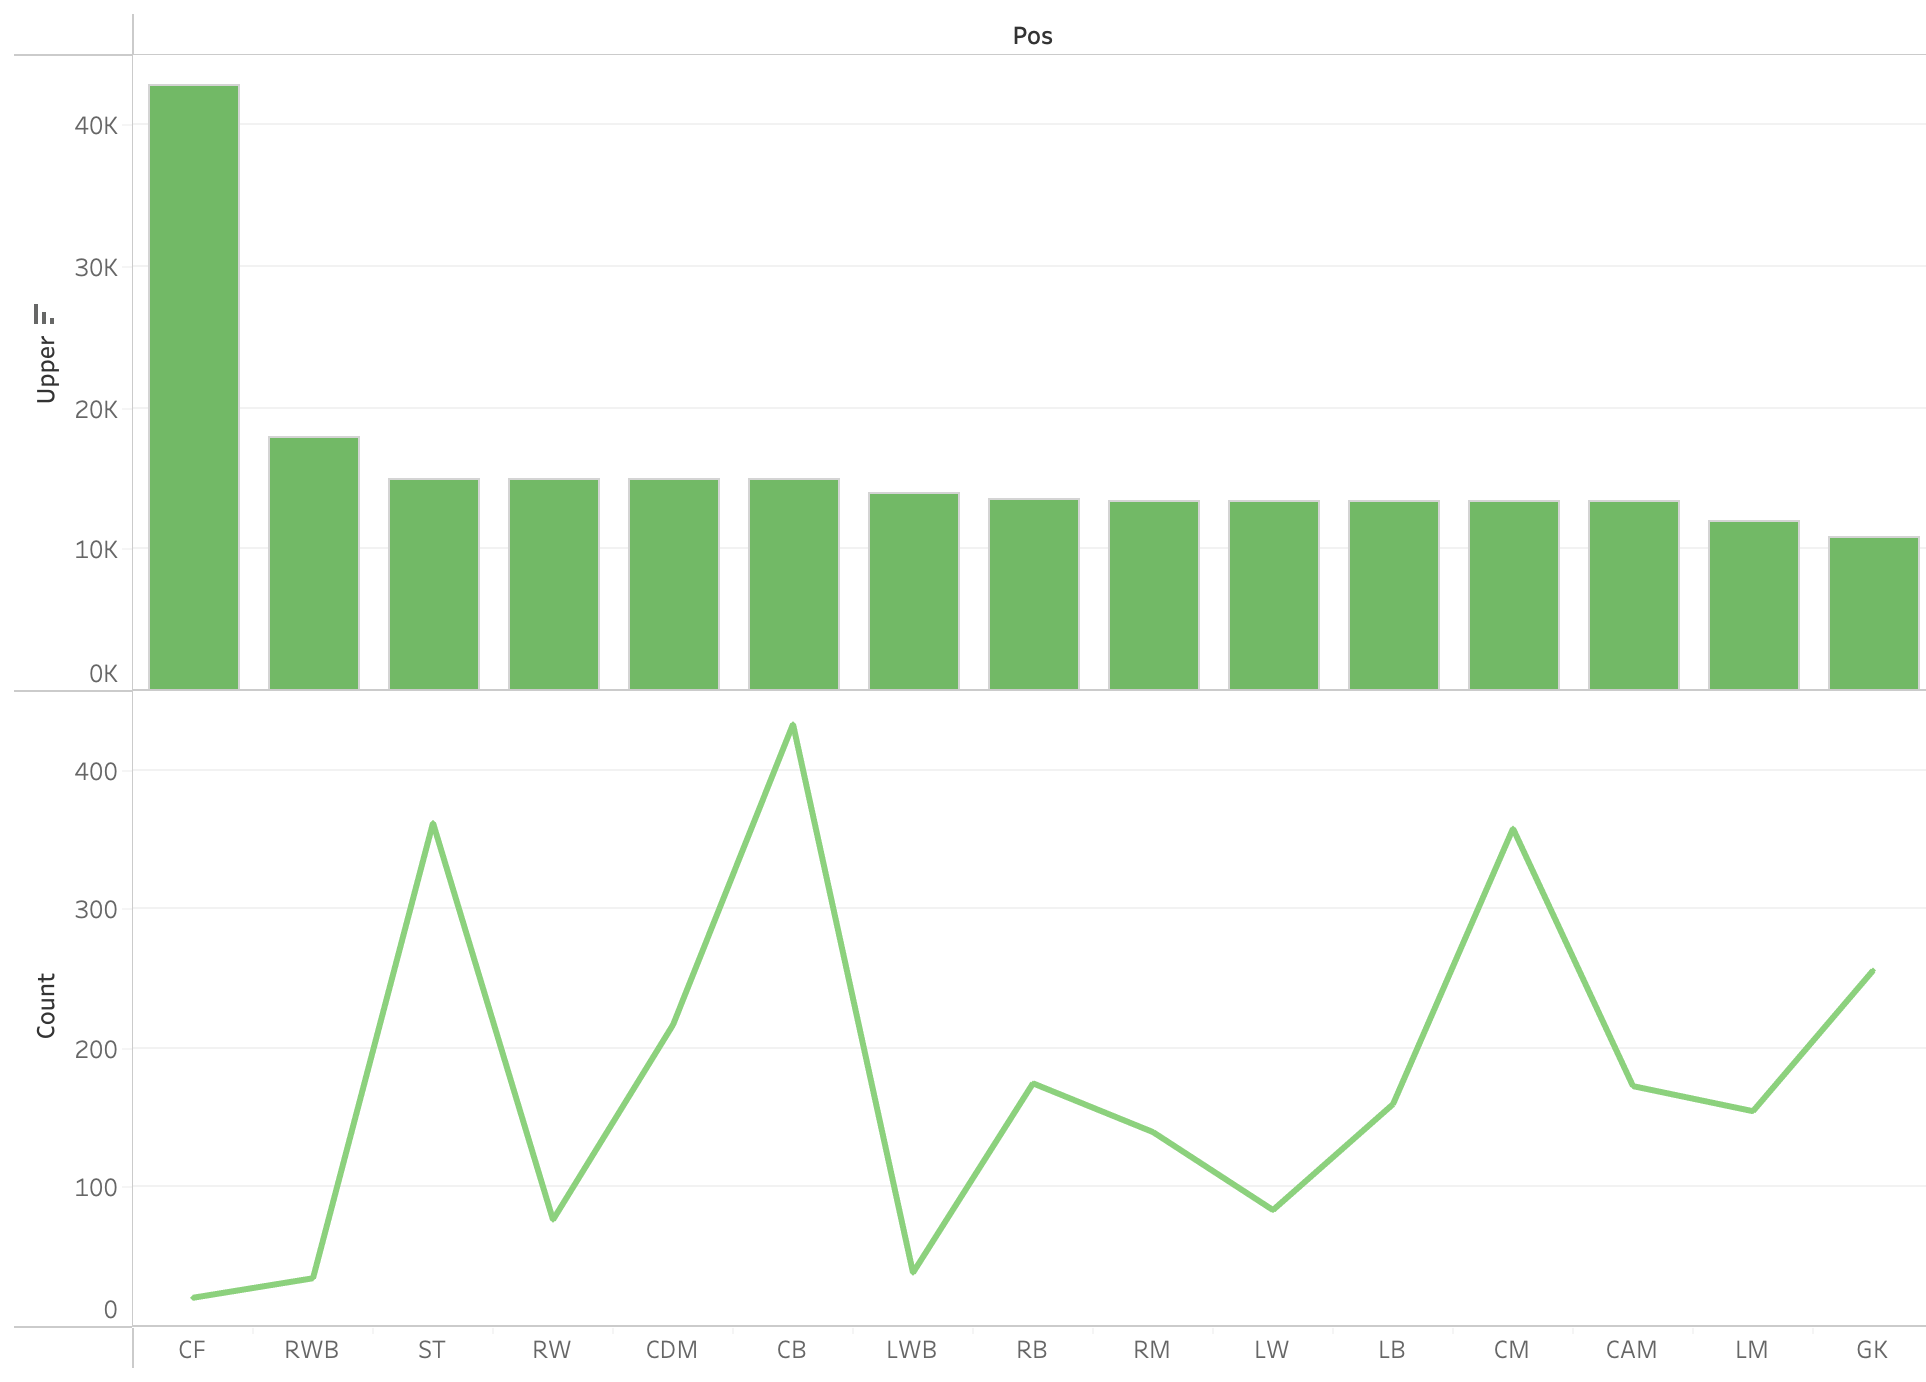

**we filter out the players earning an "outlier amount" and count the number of them within each position. It is surprising that although the upper bound of wage earned by CF is the highest amongest all the positions, there is the least amount of players are benefits from this. Thus we could make a guess that several world-known players are playing as CFs who increase the general wage level of CF by their own.**

**besides, the wage for the rest of the positions are evenly distributed between 10k to 20k, with an obvious feature that the number of the players in RW & LWB & LW is relatively small. So for future exploration, we could have a look at the abilities of the players in such range because we can see the amount earned by these players are also rekatively higher than others.**

# 2. Wage vs country

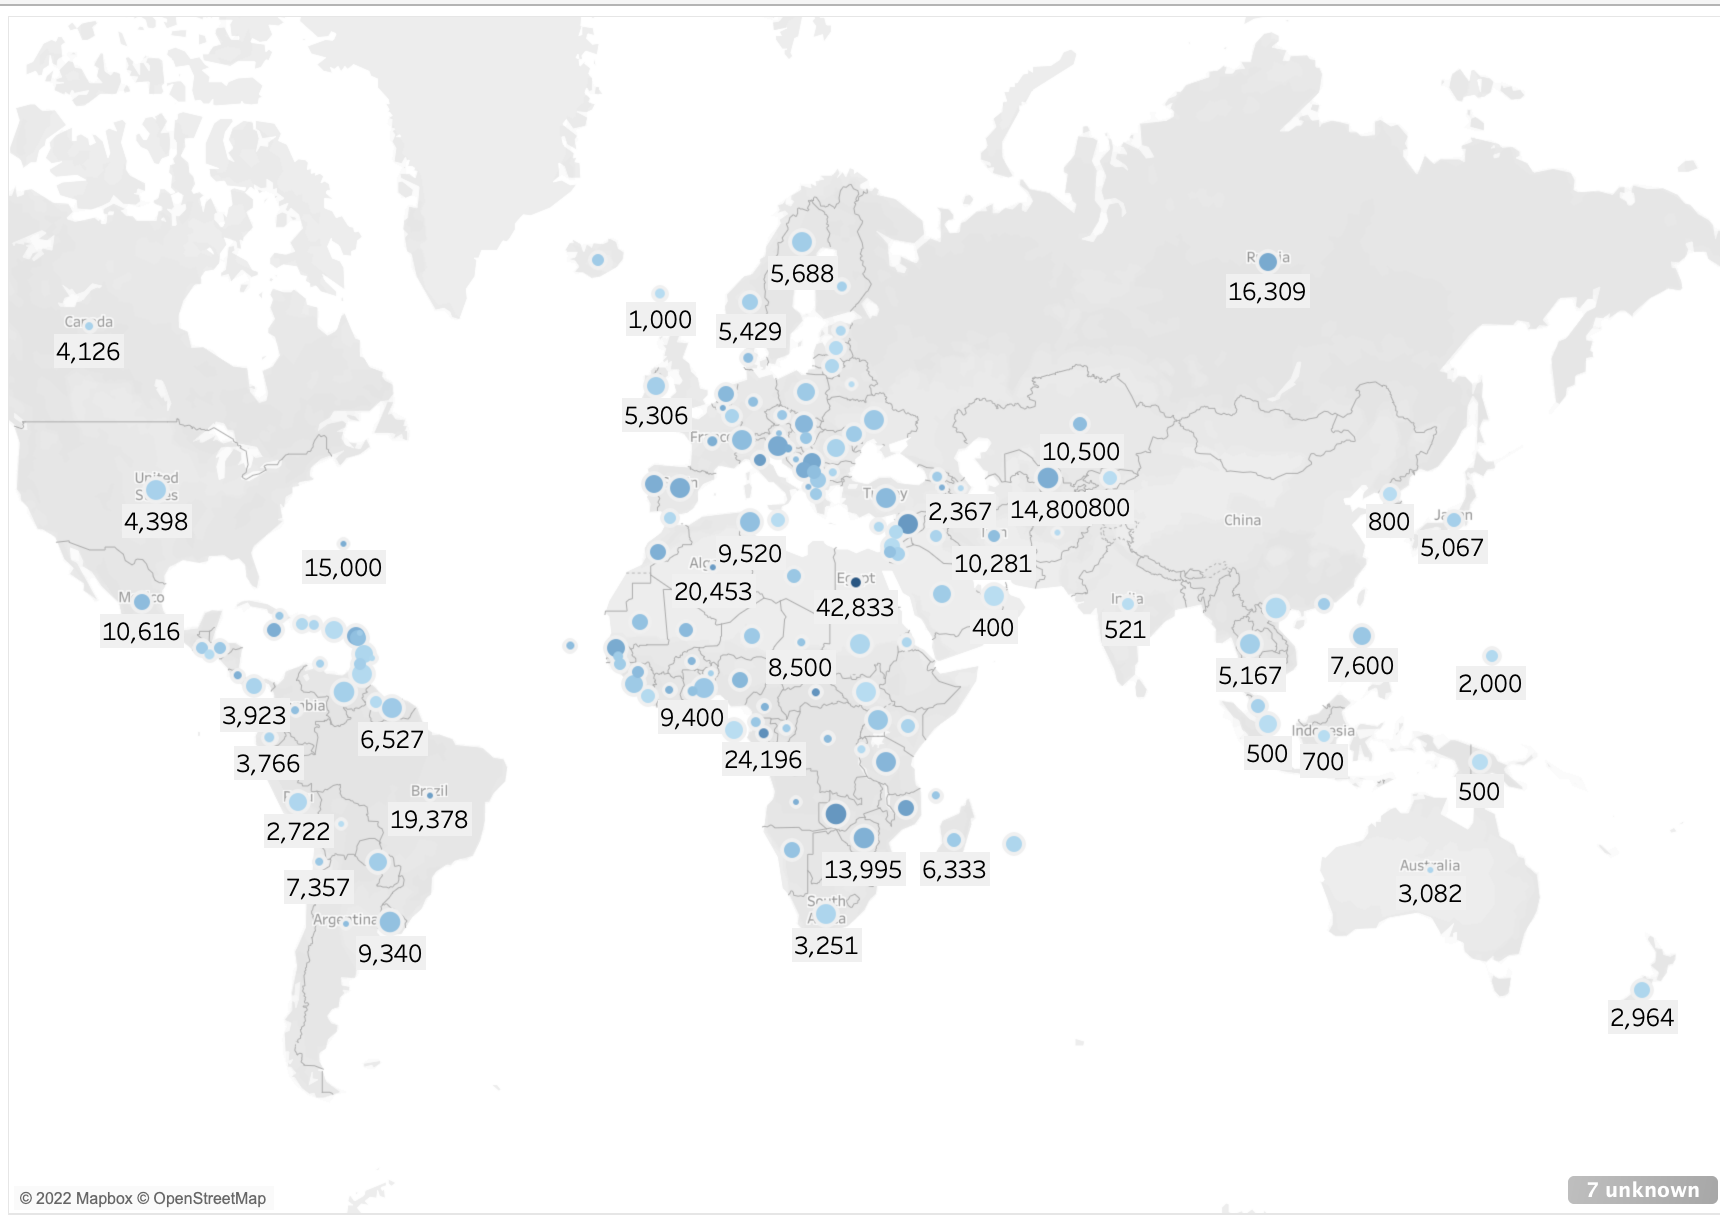

**egupt is offering the highest wage to the players while a country close to it is offering the lowest wage. A possible reason could be the wage in egupt has attracked many good players.**

# 3. potential vs age

In [305]:
potential_related_matured <- raw %>%
select(name, age, overall, potential) %>%
mutate(diff = potential - overall) %>%
filter(diff == 0) %>%
mutate(hh = "mature")

potential_related_young <- raw %>%
select(name, age, overall, potential) %>%
mutate(diff = potential - overall) %>%
filter(diff > 0) %>%
mutate(hh = "young")

potential_related <- rbind(potential_related_matured, potential_related_young)
head(potential_related)
tail(potential_related)

name             age overall potential diff hh    
1 Greg Halford     36  59      59        0    mature
2 Santiago Silva   40  71      71        0    mature
3 Sammy Bossut     35  69      69        0    mature
4 Marcelo Barovero 37  70      70        0    mature
5 Enrique Bologna  39  72      72        0    mature
6 Santiago Salcedo 39  66      66        0    mature

name                          age overall potential diff hh   
1 Daniel Ceballos Fernández     24  77      80         3   young
2 Manuel Ugarte                 20  74      84        10   young
3 Cameron Humphreys-Grant       22  68      76         8   young
4 Filip Ugrinic                 22  74      83         9   young
5 Luís Manuel Arantes Maximiano 22  78      85         7   young
6 Sergio Reguilón Rodríguez     24  80      83         3   young

**classifying whether there is still some space for the players to go beyond the current overall, with 2 levels of "muture" and "young". However, it didn't help me. in case of future usage.**

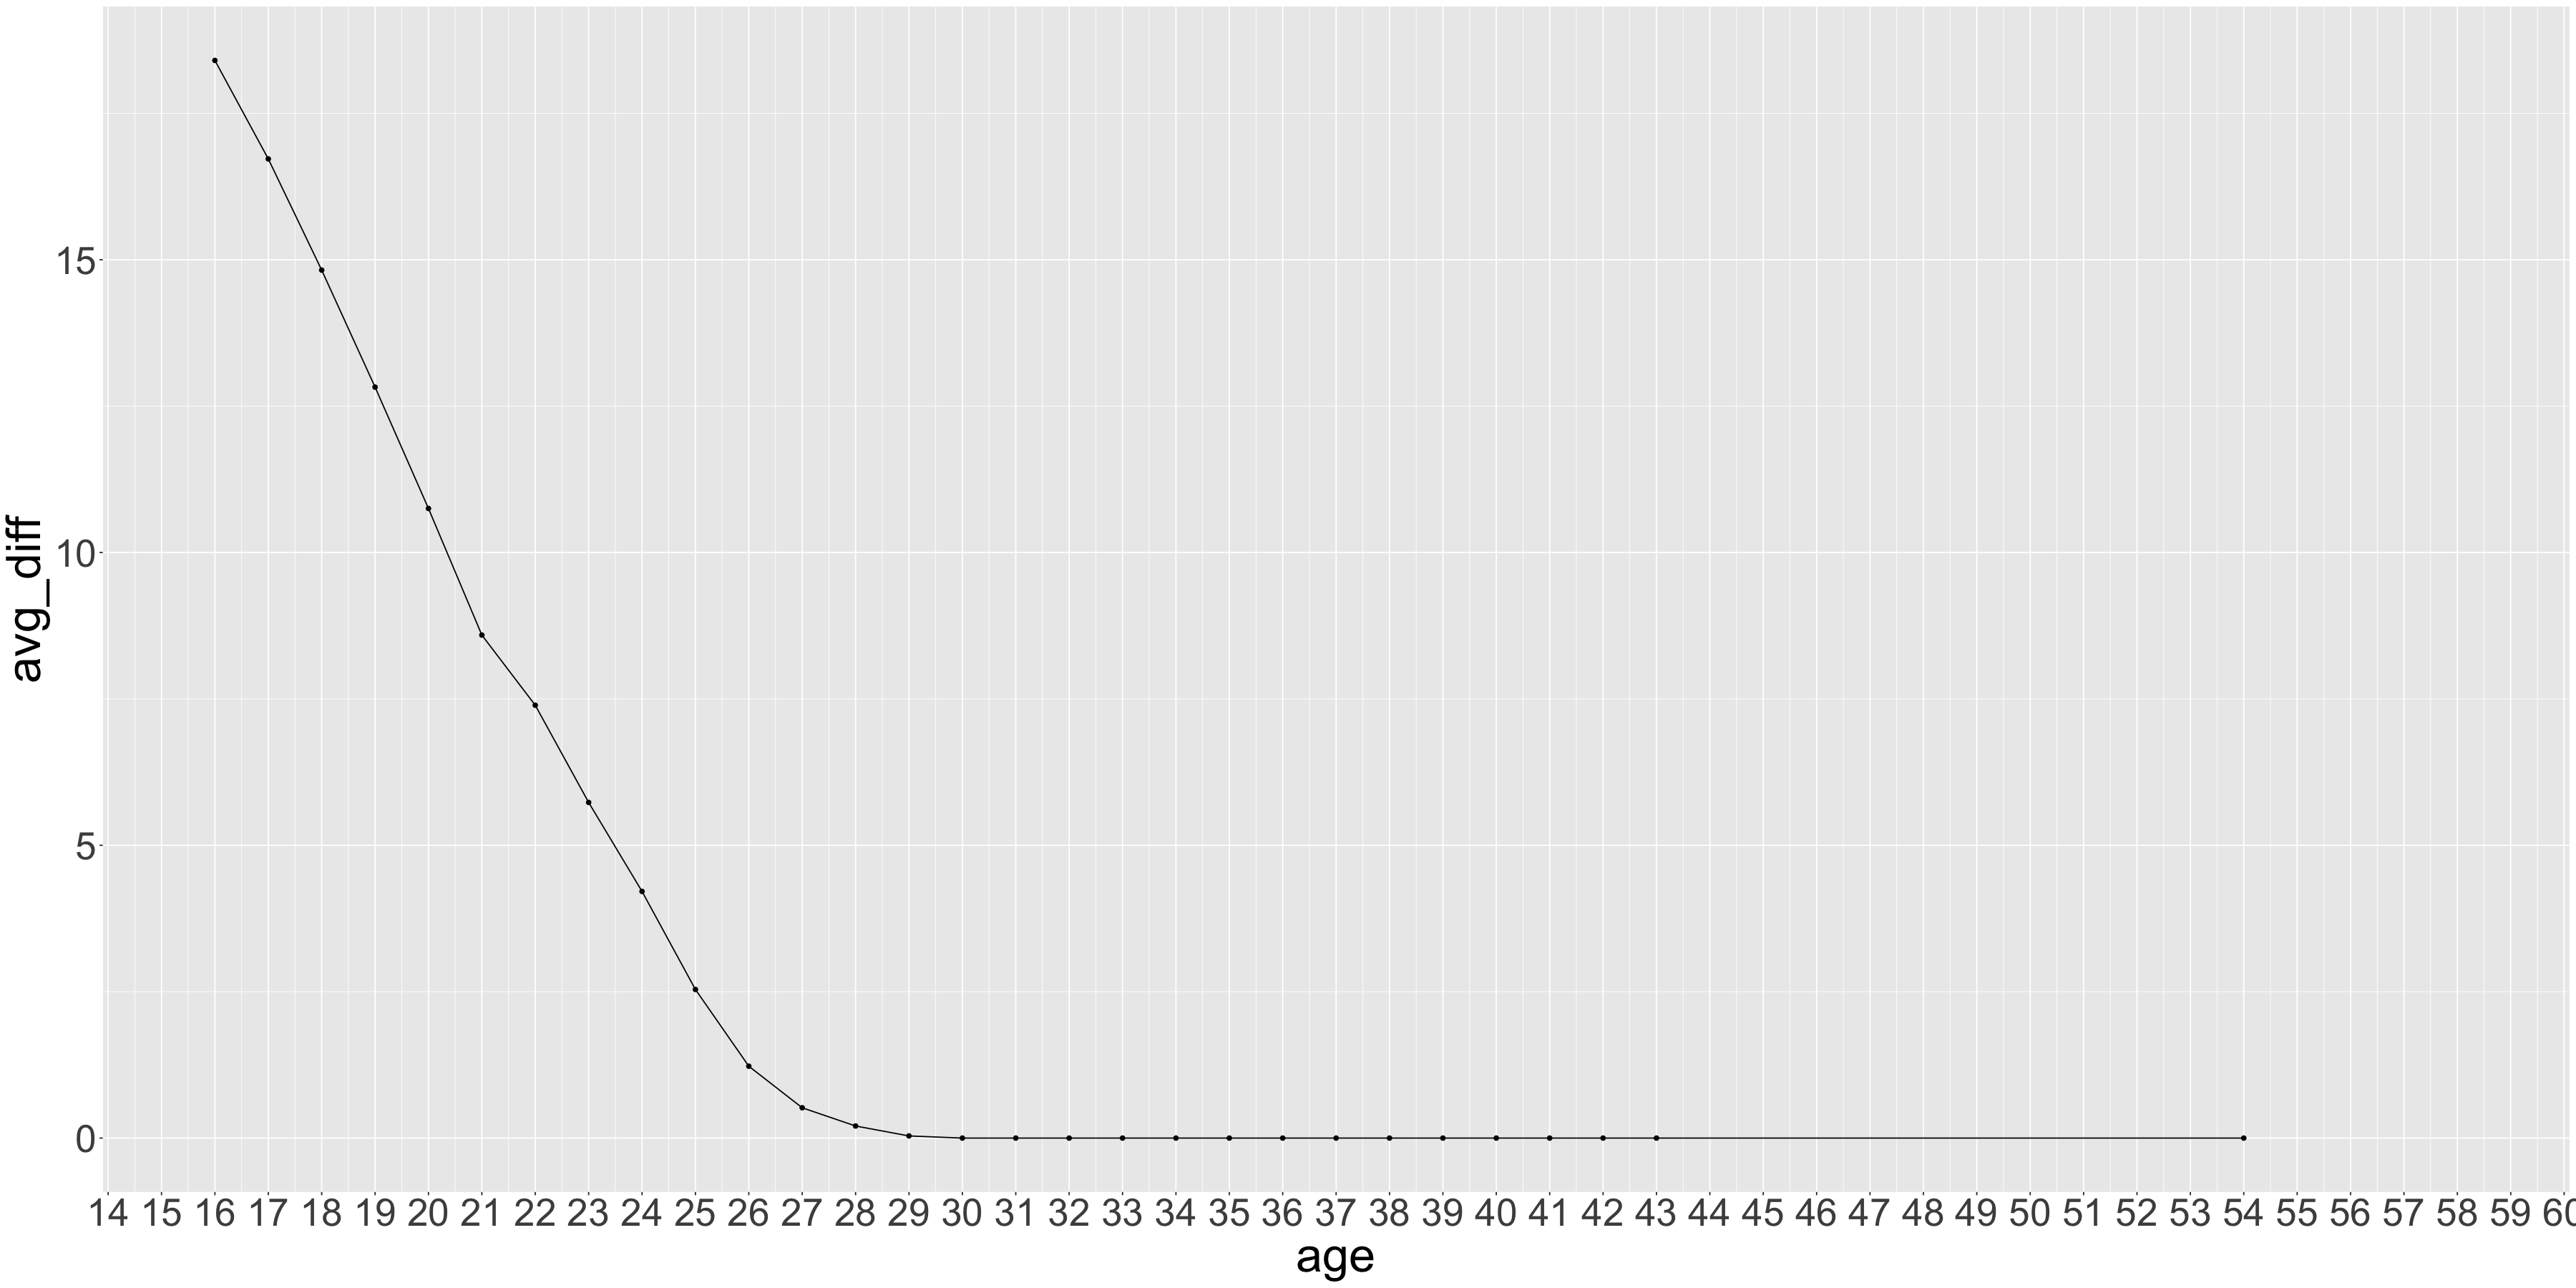

In [181]:
potential_related %>%
group_by(age)%>%
summarise(avg_diff = mean(diff)) %>%
 ggplot(aes(x = age, y = avg_diff))+
 geom_point()+
 geom_line()+
 theme(text = element_text(size = 40), legend.position="none")+
  scale_x_continuous(limits = c(16,58), breaks = c(5:60))

In [ ]:
overall vs age
potential vs age

# 4. overall vs club

In [306]:
club_overall <- raw %>%
select(club, overall, value_k, wage)%>%
group_by(club)%>%
summarise(overall_club = mean(overall),
          value_k_club = sum(value_k), 
          wage_club = mean(wage),
         num = n())%>%
arrange(desc(overall_club))

length(pull(club_overall))

head(club_overall)
tail(club_overall)

[1] 725

club                overall_club value_k_club wage_club num
1 Paris Saint-Germain 79.68966     6744725      89965.52  29 
2 Inter               79.32000     1491250      83200.00  25 
3 Real Sociedad       77.92000     2549000      33880.00  25 
4 Napoli              77.36000     2597600      58080.00  25 
5 Flamengo            77.20000      987000      35100.00  10 
6 Juventus            76.86667     4855000      60733.33  30

club                     overall_club value_k_club wage_club num
1 NorthEast United FC      54.00000     1420          500.0000  8 
2 Finn Harps               53.87500     1905          500.0000  8 
3 Longford Town            53.71429     2020          510.7143 14 
4 Club Deportivo Palestino 53.33333      695          500.0000  3 
5 Hebei FC                 50.22222     1650         1338.8889  9 
6 Qingdao FC               48.50000      205         1750.0000  4

# 5. overall vs country

In [307]:
country_overall <- raw %>%
select(country, overall, value_k, wage)%>%
group_by(country)%>%
summarise(overall_country = mean(overall),
          value_k_country = sum(value_k), 
          wage_country = mean(wage),
         num = n())%>%
arrange(desc(overall_country))

length(pull(country_overall))

head(country_overall)
tail(country_overall)

[1] 159

country    overall_country value_k_country wage_country num
1 Libya      73.00000          155000         7666.667      3
2 Mozambique 72.33333           54000        18666.667      3
3 Egypt      72.20000          515550        42833.333     15
4 Syria      72.00000           19000        21500.000      2
5 Brazil     71.62883        23835740        19377.568    555
6 Slovenia   71.08333          916825        16086.111     36

country     overall_country value_k_country wage_country num
1 Guyana      58.20000          2285          1580.0000     5 
2 China PR    56.40816        243230          3095.9184    98 
3 Singapore   55.00000           300           500.0000     1 
4 South Sudan 54.75000          1095           937.5000     4 
5 India       54.63636         20705           521.2121    99 
6 Indonesia   53.50000           430           700.0000     2

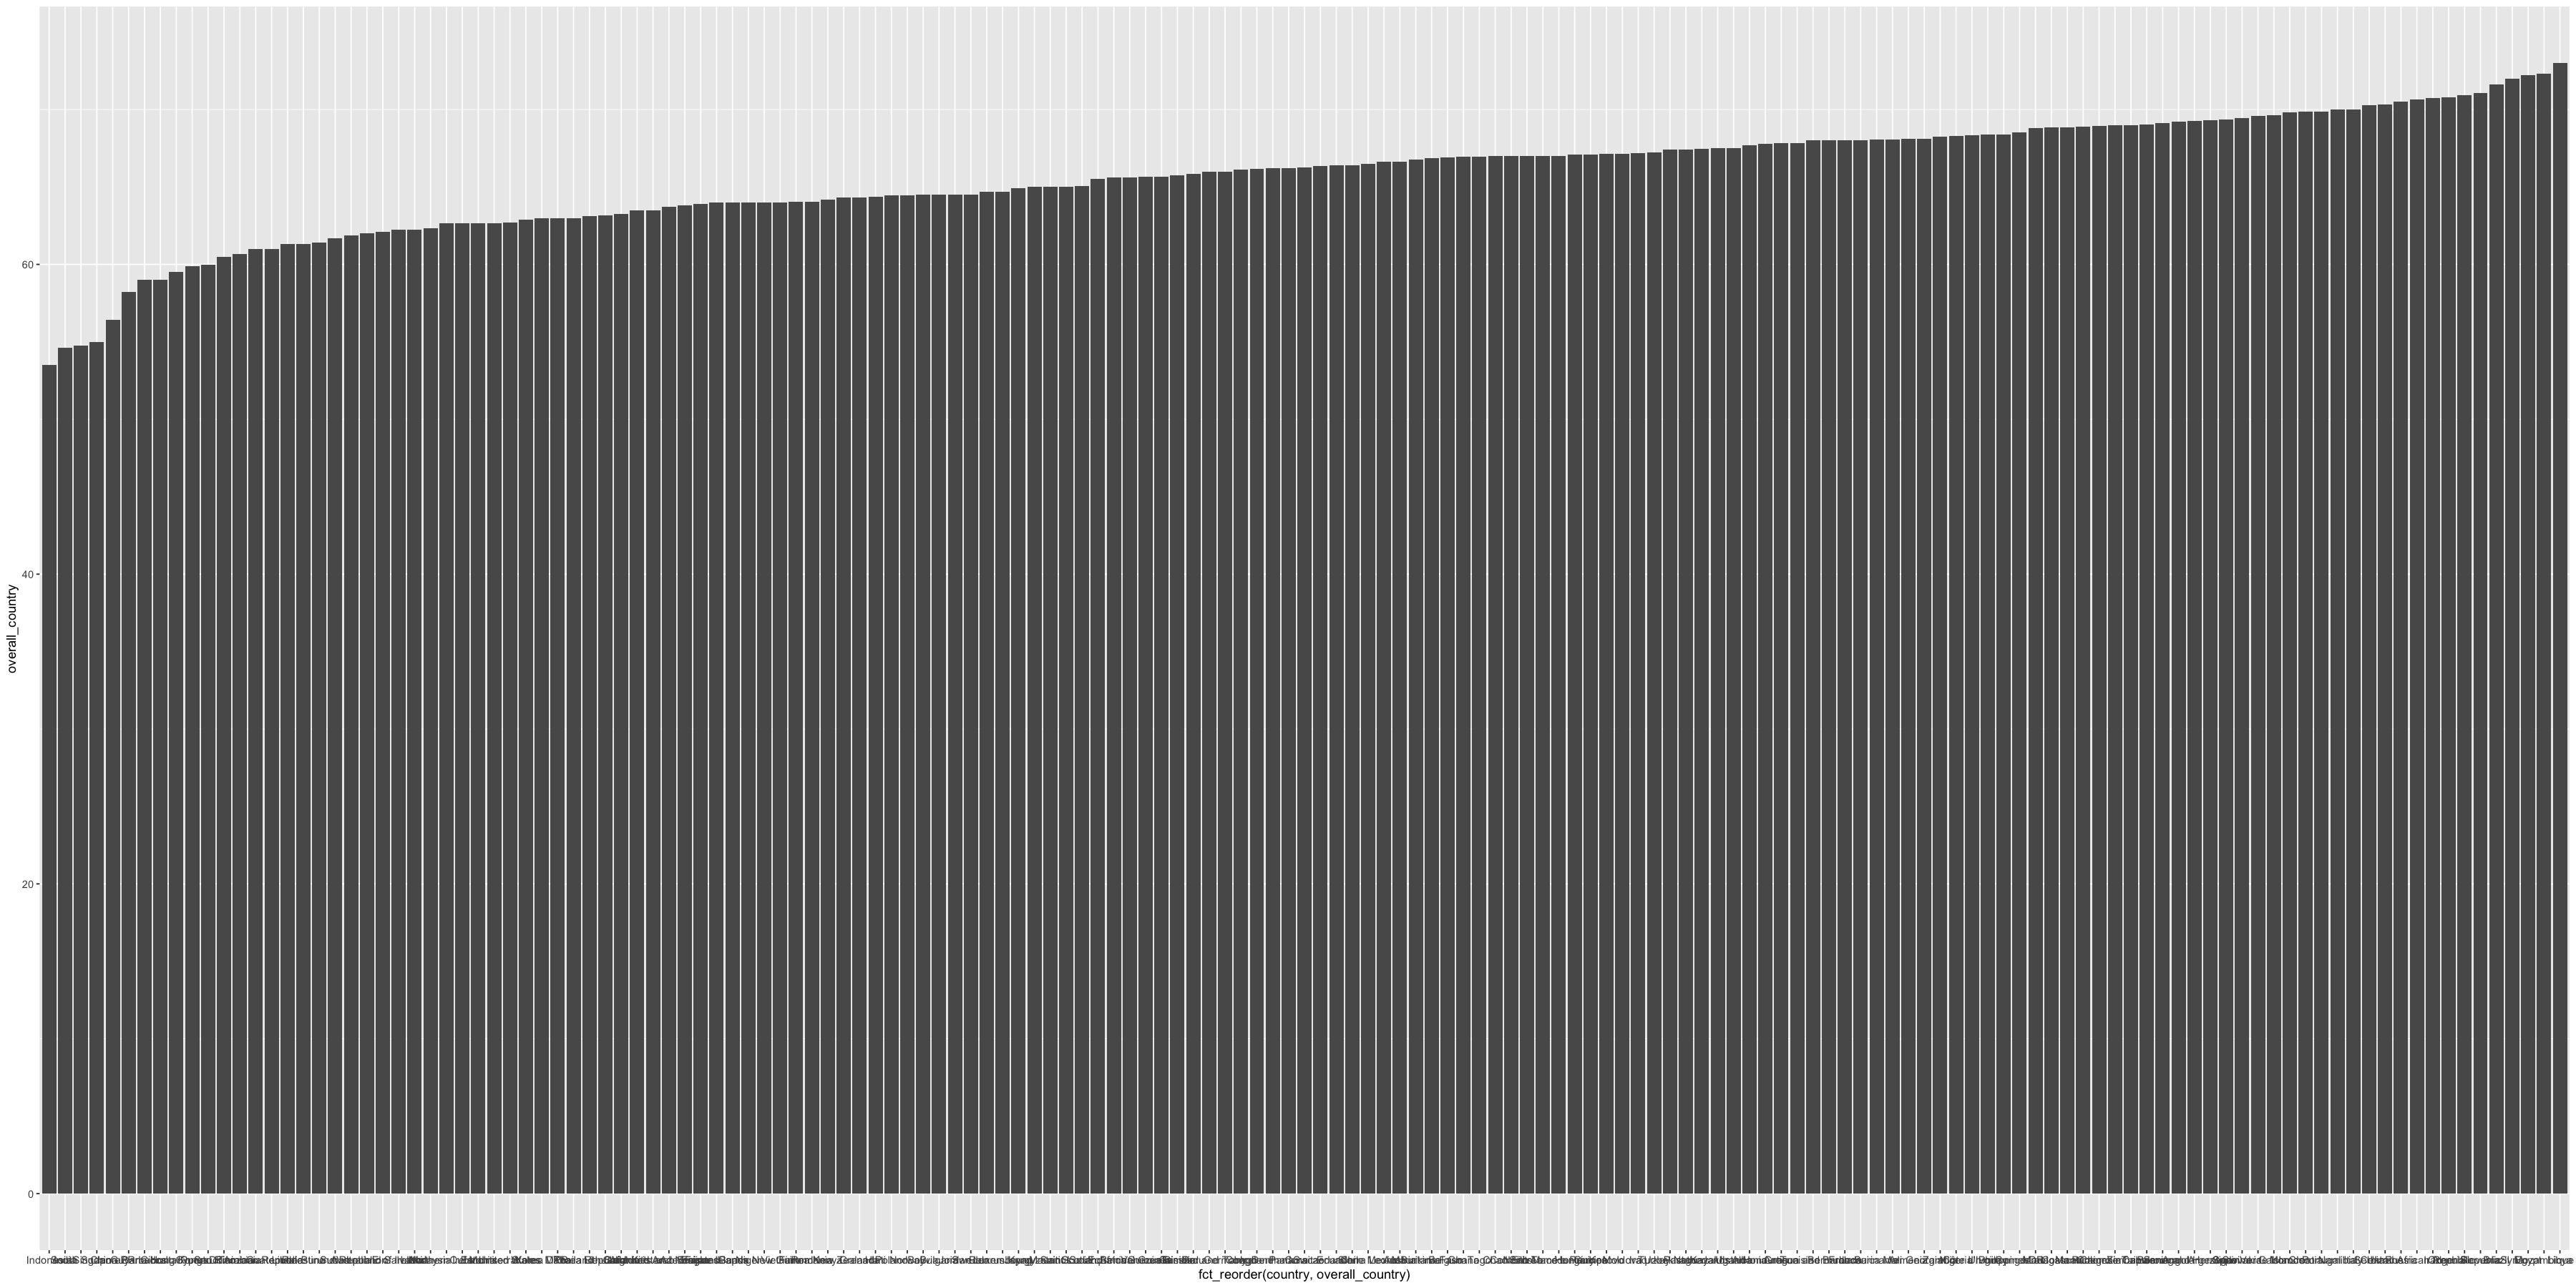

In [185]:
country_overall %>%
ggplot(aes(x = fct_reorder(country,overall_country), 
           y = overall_country,
          .desc = FALSE))+
geom_bar(stat = "identity")

# 6. ACE

In [186]:
raw_cols <- raw %>%
colnames() 
length(raw_cols)
raw_cols[10:42]

[1] 42

[1] "crossing"            "finishing"           "heading_accuracy"   
 [4] "short_passing"       "volleys"             "dribbling"          
 [7] "curve"               "fk_accuracy"         "long_passing"       
[10] "ball_control"        "acceleration"        "sprint_speed"       
[13] "agility"             "reactions"           "balance"            
[16] "shot_power"          "jumping"             "stamina"            
[19] "strength"            "long_shots"          "aggression"         
[22] "interceptions"       "positioning"         "vision"             
[25] "penalties"           "composure"           "defensive_awareness"
[28] "standing_tackle"     "sliding_tackle"      "diving"             
[31] "handling"            "kicking"             "reflexes"

In [308]:
fea <- raw %>%
select(raw_cols[10:42])%>%
summarise_all(quantile)
fea
#write_csv(slice(fea, 3), "3st_quantile.csv")

crossing finishing heading_accuracy short_passing volleys dribbling curve
1  6        2         5                7             3       4         6   
2 40       33        45               56            32      53        37   
3 55       53        56               63            45      63        51   
4 64       64        65               69            58      70        63   
5 94       95        93               93            90      96        93   
  fk_accuracy long_passing ball_control ⋯ vision penalties composure
1  4           9            9           ⋯ 10      7        12       
2 32          46           57           ⋯ 47     40        52       
3 44          57           64           ⋯ 57     50        60       
4 57          65           70           ⋯ 65     61        68       
5 94          93           95           ⋯ 95     92        96       
  defensive_awareness standing_tackle sliding_tackle diving handling kicking
1  4                   7               6              2      2        2     
2 30                  29              26              8      8        8     
3 52                  56              53             11     11       11     
4 64                  66              64             14     14       14     
5 92                  93              90             90     90       93     
  reflexes
1  2      
2  8      
3 11      
4 14      
5 90

In [206]:
quantile_3st <- read_csv("3st_quantile.csv") %>%
pivot_longer(raw_cols[10:42],
             names_to = "features", 
             values_to = "value") %>%
pull()
quantile_3st

Rows: 1 Columns: 33

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (33): crossing, finishing, heading_accuracy, short_passing, volleys, dri...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] 55 53 56 63 45 63 51 44 57 64 69 69 67 63 67 60 65 67 66 53 59 53 11 57 50
[26] 60 52 56 53 11 11 11 11

# 改 3->2 varible不手写

In [207]:
raw%>%
filter(crossing>55,
finishing>53,
heading_accuracy>56,
short_passing>63,
volleys>45,
dribbling>63,
curve>51,
fk_accuracy>44,
long_passing>57,
ball_control>64,
acceleration>69,
sprint_speed>69,
agility>67,
reactions>63,
balance>67,
shot_power>60,
jumping>65,
stamina>67,
strength>66,
long_shots>53,
aggression>59,
interceptions>53,
positioning>11,
vision>57,
penalties>50,
composure>60,
defensive_awareness>52,
standing_tackle>56,
sliding_tackle>53,
diving>11,
handling>11,
kicking>11,
reflexes>11)

name         country age overall potential club                pos value_k
1 Filip Kostić Serbia  28  84      84        Eintracht Frankfurt LM  425000 
  wage  crossing ⋯ vision penalties composure defensive_awareness
1 52000 91       ⋯ 81     66        80        69                 
  standing_tackle sliding_tackle diving handling kicking reflexes
1 72              68             13     14       12      13

# 7. Position & abilities

## 7.1 attacking

In [310]:
a <- 1 #TBA
b <- 1 #TBA
c <- 1 #TBA
d <- 1 #TBA
e <- 1 #TBA
attacking <- raw%>%
select(pos, crossing,
finishing,
heading_accuracy,
short_passing,
volleys) %>%
mutate(attacking_overall = (a * crossing + b * finishing + c * heading_accuracy + d * short_passing + e * volleys)/5)
head(attacking)

pos crossing finishing heading_accuracy short_passing volleys
1 CB  53       49        62               60            54     
2 ST  52       71        78               64            69     
3 GK  12       13        12               36            11     
4 GK  14       13        13               36            18     
5 GK  21       13        10               34            10     
6 ST  59       68        69               63            60     
  attacking_overall
1 55.6             
2 66.8             
3 16.8             
4 18.8             
5 17.6             
6 63.8

In [216]:
options(repr.plot.width=30, repr.plot.height=30)

pos attacking_mean_pos
1  CF  62.20492          
2  ST  60.08017          
3  CAM 58.93104          
4  RW  58.48262          
5  LW  58.28632          
6  LM  58.19508          
7  RM  57.63656          
8  CM  57.38750          
9  CDM 54.60312          
10 RWB 52.99598          
11 LWB 52.87302          
12 LB  52.76876          
13 RB  52.47256          
14 CB  46.28950          
15 GK  15.36165

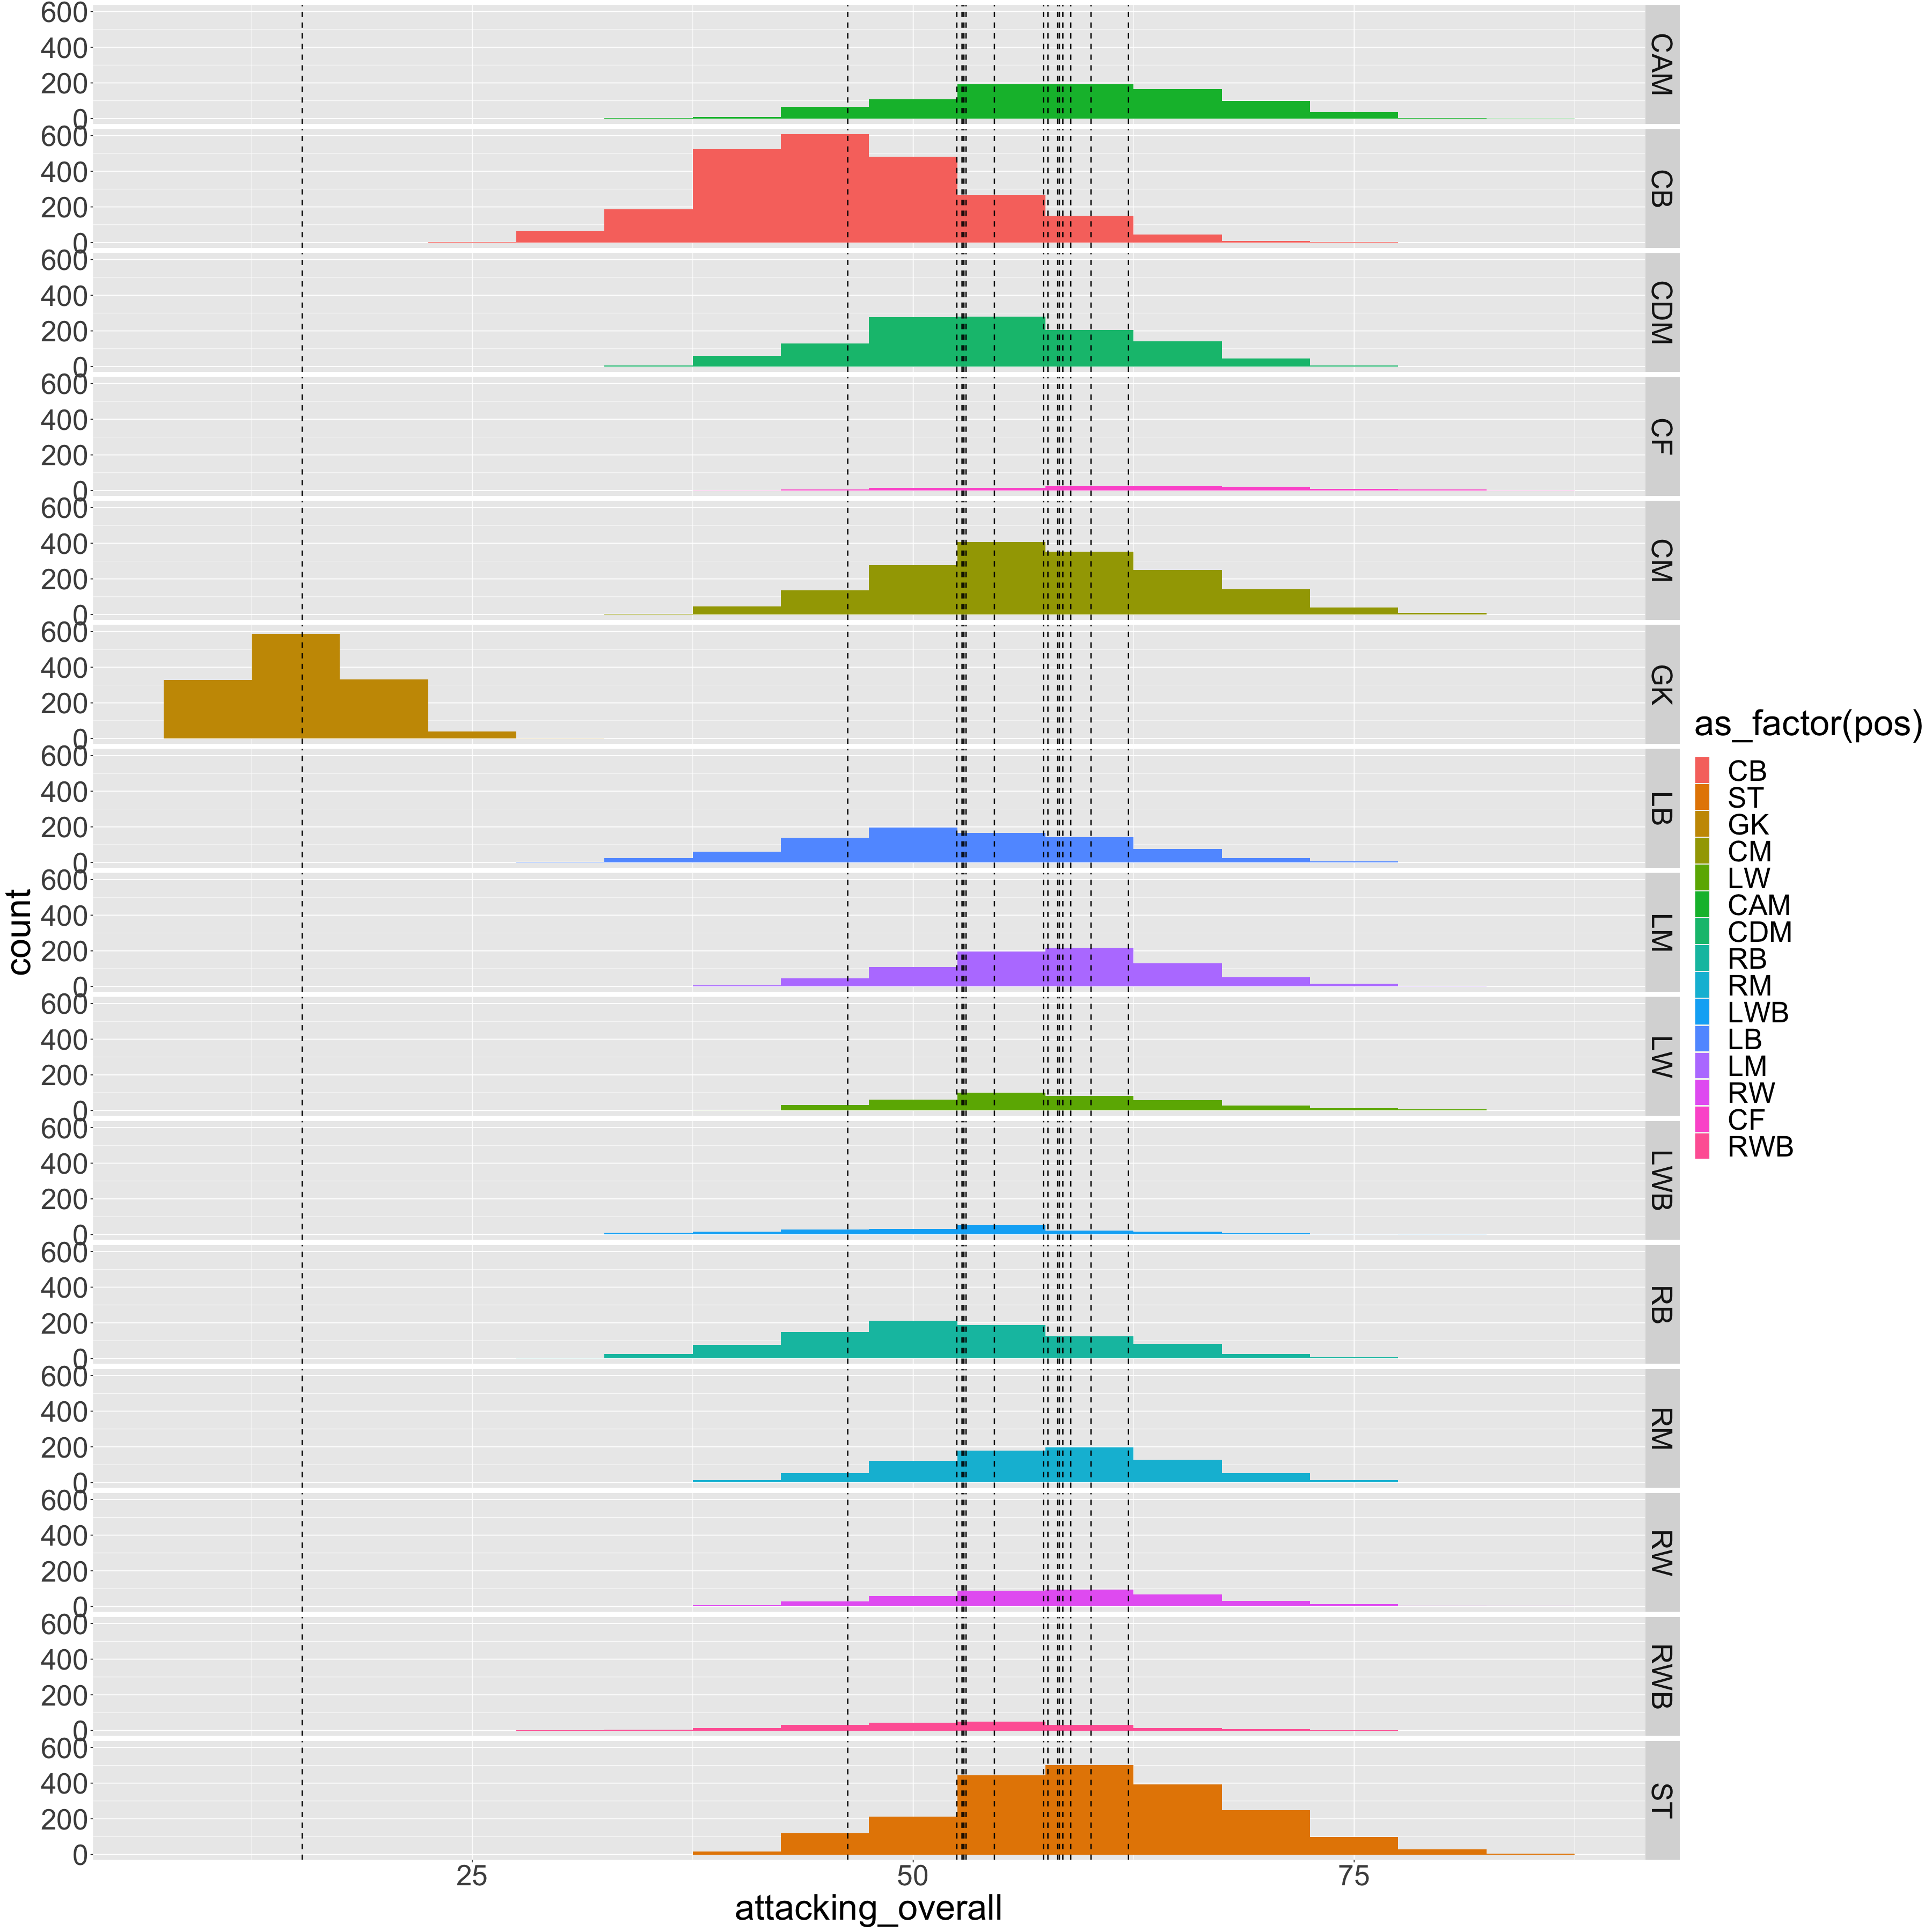

In [312]:
attacking_mean_by_pos <-attacking %>%
group_by(pos) %>%
summarise(attacking_mean_pos = mean(attacking_overall))%>%
pull(attacking_mean_pos)

attacking_mean_by_pos_ordered <- attacking %>%
group_by(pos) %>%
summarise(attacking_mean_pos = mean(attacking_overall)) %>%
arrange(desc(attacking_mean_pos))
attacking_mean_by_pos_ordered

attacking_pos_plot <- attacking %>%
select(pos, attacking_overall) %>%
ggplot(aes(x = attacking_overall, fill = as_factor(pos)))+
geom_histogram(binwidth = 5)+
facet_grid(rows = vars(pos))+
theme(text = element_text(size = 40))+
geom_vline(xintercept = attacking_mean_by_pos, linetype = "dashed", size = 0.7)
attacking_pos_plot
#ggsave("attacking_pos_plot.jpg", attacking_pos_plot)

## 7.2 Skill

In [239]:
f <- 1 #TBA
g <- 1 #TBA
h <- 1 #TBA
i <- 1 #TBA
j <- 1 #TBA

skill <- raw%>%
select(pos, dribbling,
curve,
fk_accuracy,
long_passing,
ball_control) %>%
mutate(skill_overall = f*dribbling+g*curve+h*fk_accuracy+i*long_passing+j*ball_control)
head(skill)

pos dribbling curve fk_accuracy long_passing ball_control skill_overall
1 CB  54        58    55          58           55           280          
2 ST  64        60    60          59           69           312          
3 GK  11        11    15          38           32           107          
4 GK  18        19    19          23           12            91          
5 GK  22        16    18          21           32           109          
6 ST  66        65    68          59           64           322

pos skill_mean_pos
1  CF  325.27869     
2  CAM 325.10309     
3  CM  315.63522     
4  LM  308.05045     
5  RW  307.70781     
6  LW  306.63158     
7  RM  304.09669     
8  CDM 296.37348     
9  LWB 284.43915     
10 LB  284.24970     
11 ST  276.58119     
12 RWB 276.51759     
13 RB  275.34267     
14 CB  229.73057     
15 GK   88.11646

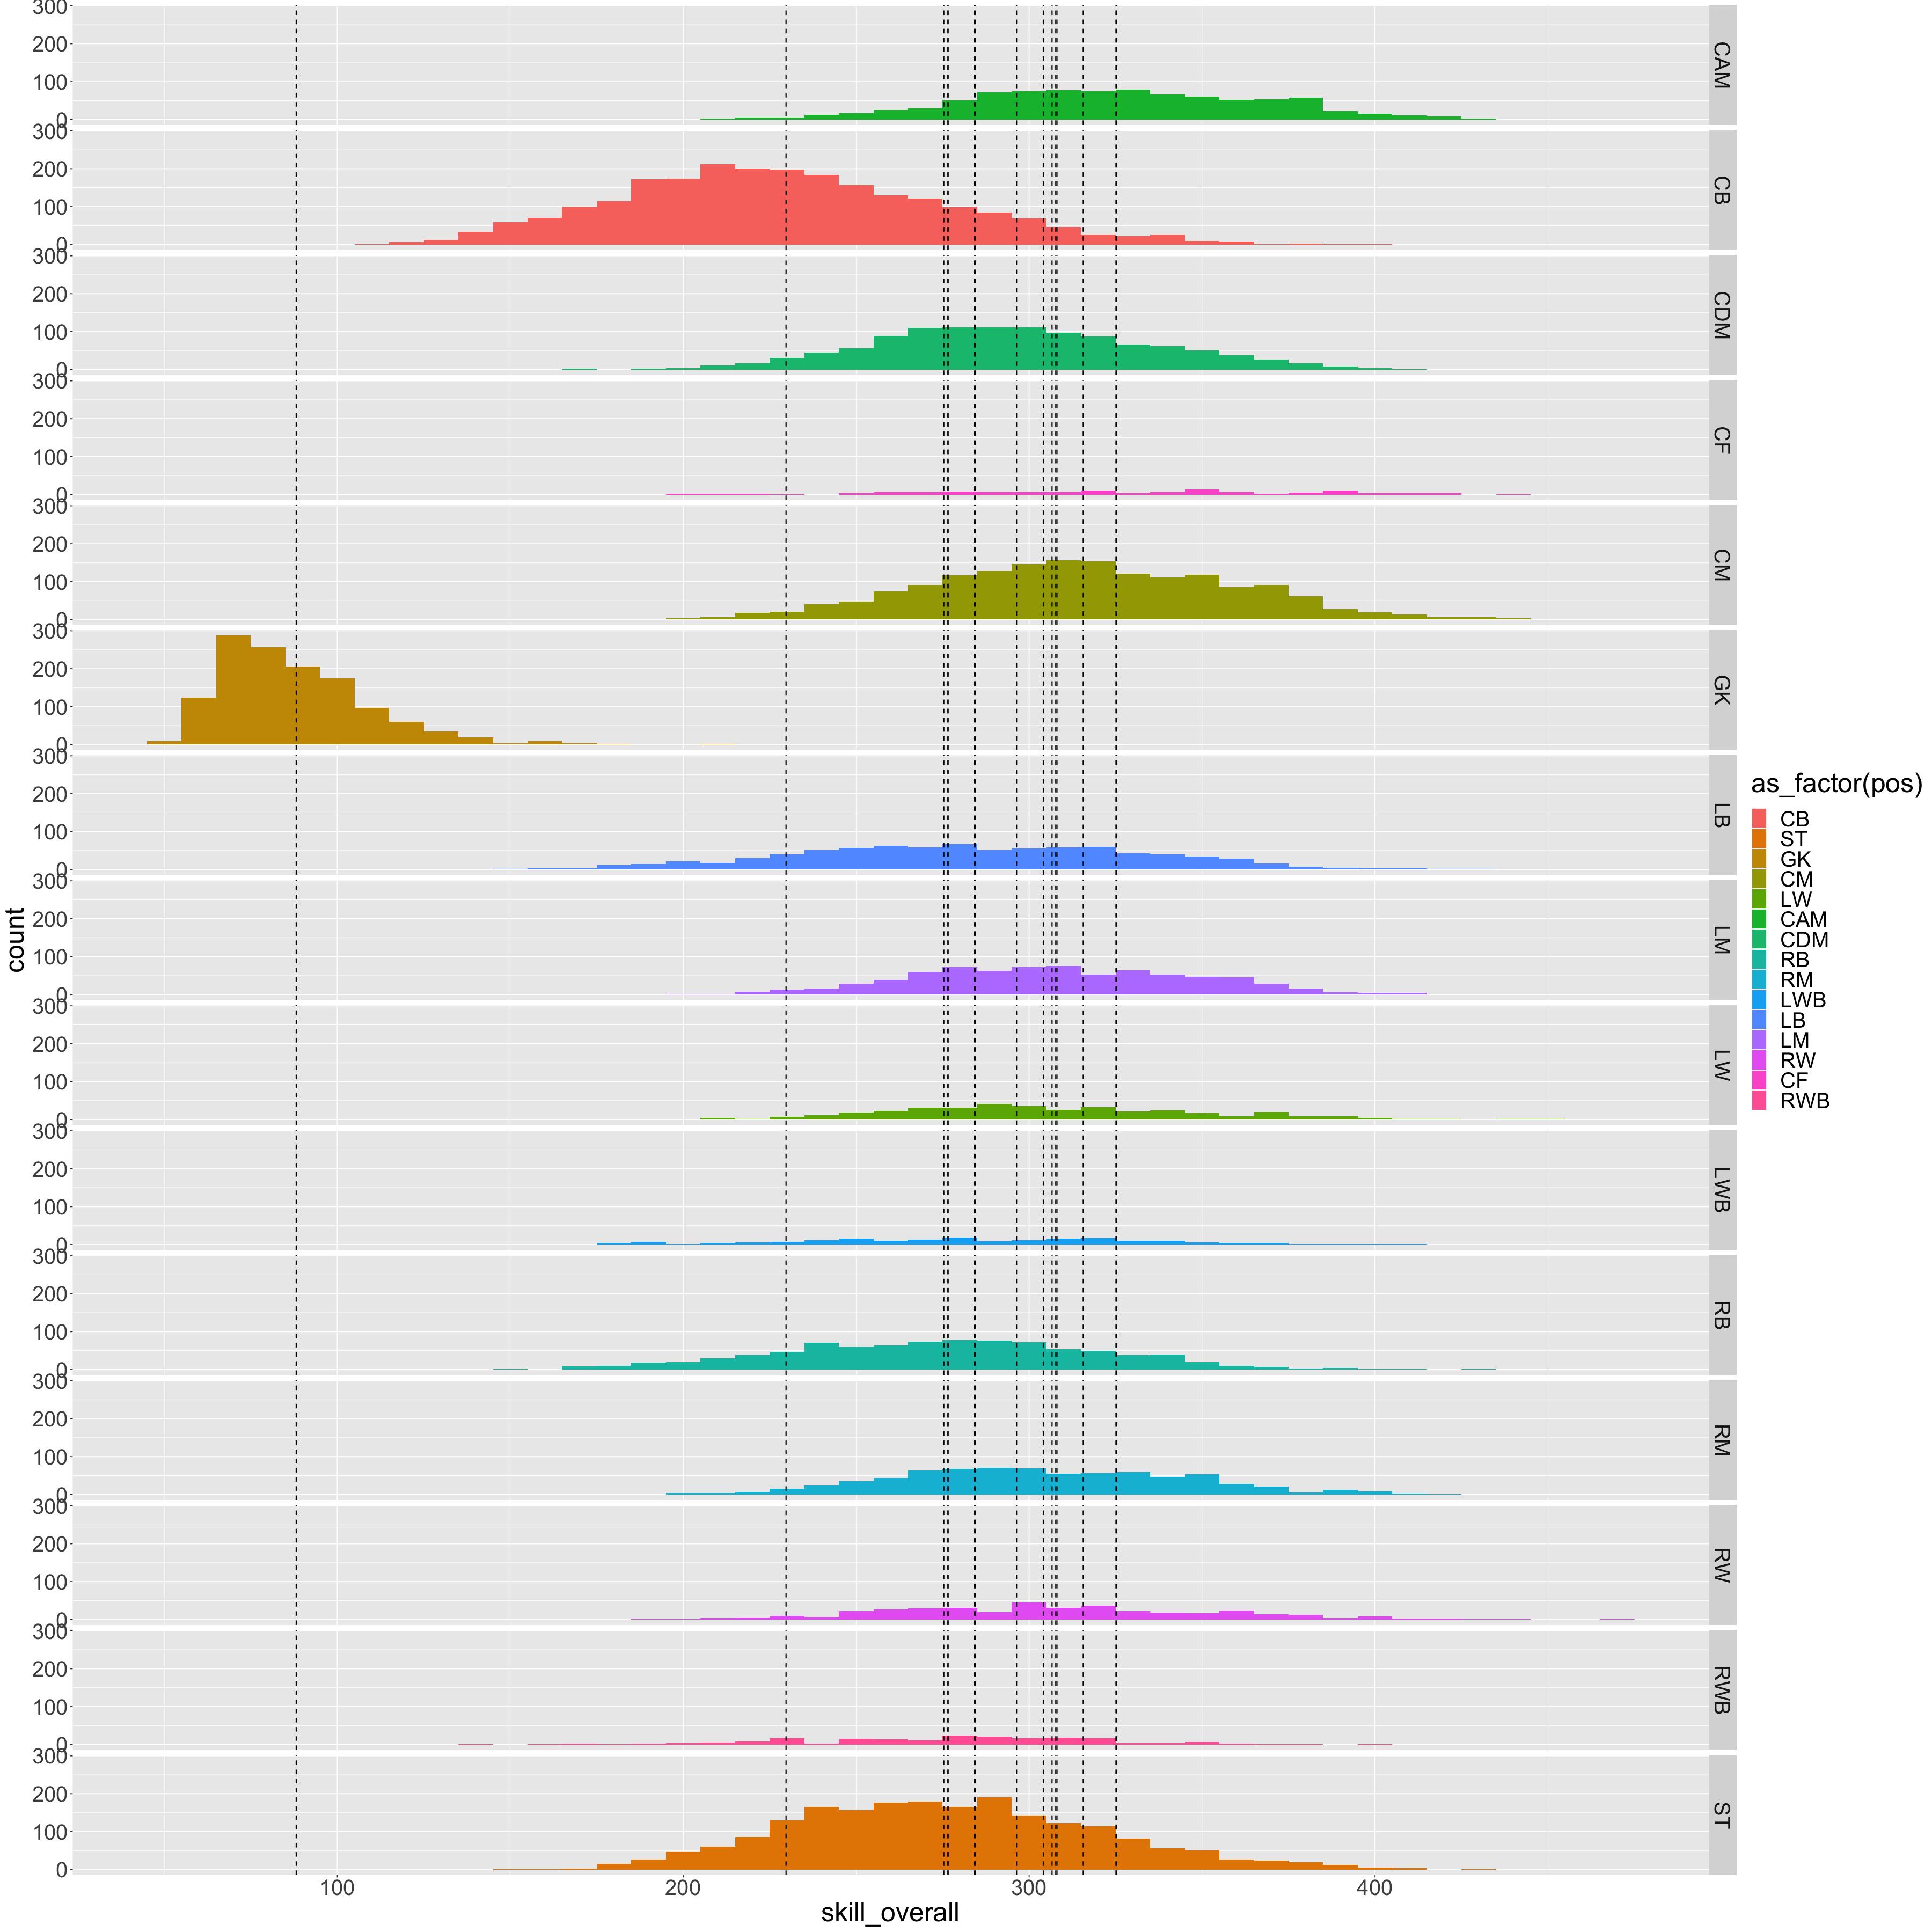

In [276]:
skill_mean_by_pos <-skill %>%
group_by(pos) %>%
summarise(skill_mean_pos = mean(skill_overall))%>%
pull(skill_mean_pos)

skill_mean_by_pos_ordered <- skill %>%
group_by(pos) %>%
summarise(skill_mean_pos = mean(skill_overall))%>%
arrange(desc(skill_mean_pos))
skill_mean_by_pos_ordered

skill_pos_plot <- skill %>%
select(pos, skill_overall) %>%
ggplot(aes(x = skill_overall, fill = as_factor(pos)))+
geom_histogram(binwidth = 10)+
facet_grid(rows = vars(pos))+
theme(text = element_text(size = 30))+
geom_vline(xintercept = skill_mean_by_pos, linetype = "dashed", size = 0.6)
skill_pos_plot
#ggsave("skill_pos_plot.jpg", skill_pos_plot)

## 7.3 Movement

In [255]:
k <- 1 #TBA
l <- 1 #TBA
m <- 1 #TBA
n <- 1 #TBA
o <- 1 #TBA

movement <- raw%>%
select(pos, acceleration,
sprint_speed,
agility,
reactions,
balance) %>%
mutate(movement_overall = k*acceleration+
l*sprint_speed+
m*agility+
n*reactions+
o*balance)
head(movement)

pos acceleration sprint_speed agility reactions balance movement_overall
1 CB  45           45           31      57        33      211             
2 ST  34           34           52      75        51      246             
3 GK  42           47           47      63        42      241             
4 GK  34           33           31      66        57      221             
5 GK  44           40           43      70        47      244             
6 ST  66           70           68      65        63      332

pos movement_mean_pos
1  CF  371.8115         
2  RW  370.3627         
3  LW  369.7789         
4  RM  366.6728         
5  LM  365.7697         
6  CAM 352.7022         
7  RWB 352.0302         
8  LB  351.2935         
9  RB  351.2419         
10 LWB 348.7037         
11 CM  338.9387         
12 ST  334.2176         
13 CDM 320.9515         
14 CB  292.4372         
15 GK  212.6095

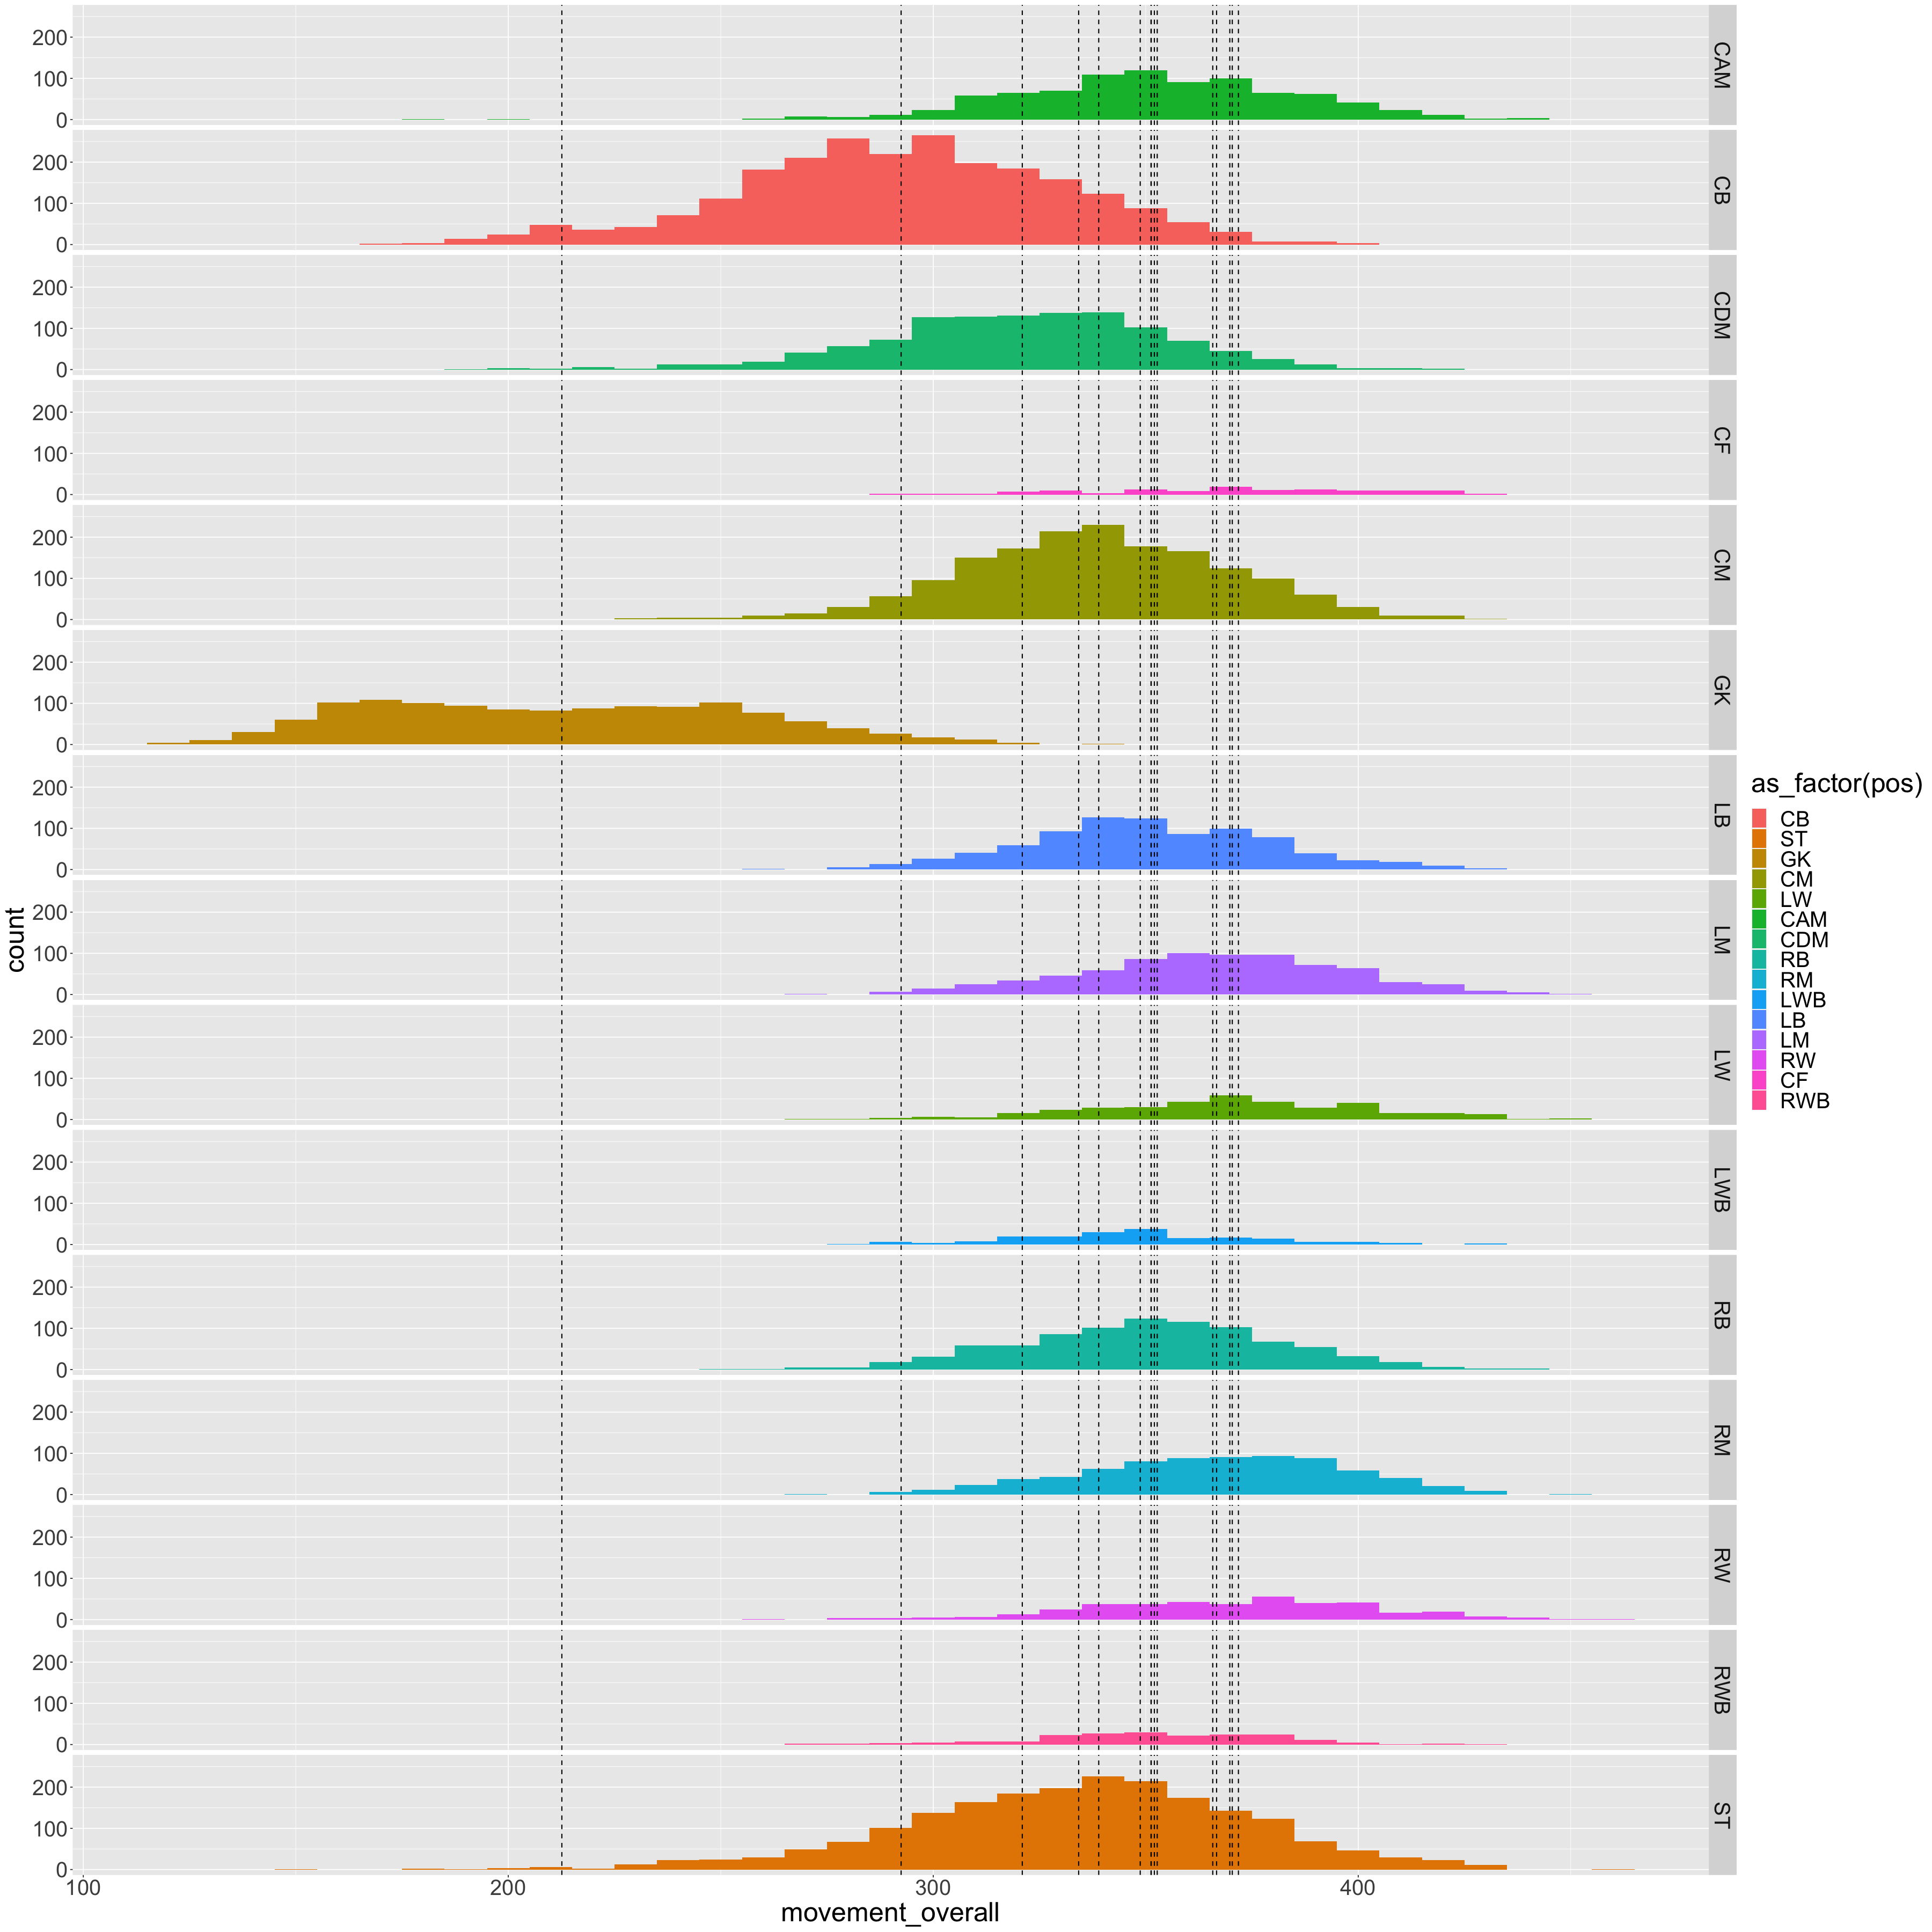

In [279]:
movement_mean_by_pos <-movement %>%
group_by(pos) %>%
summarise(movement_mean_pos = mean(movement_overall))%>%
pull(movement_mean_pos)

movement_mean_by_pos_ordered <- movement %>%
group_by(pos) %>%
summarise(movement_mean_pos = mean(movement_overall))%>%
arrange(desc(movement_mean_pos))
movement_mean_by_pos_ordered

movement_pos_plot <- movement %>%
select(pos, movement_overall) %>%
ggplot(aes(x = movement_overall, fill = as_factor(pos)))+
geom_histogram(binwidth = 10)+
facet_grid(rows = vars(pos))+
theme(text = element_text(size = 30))+
geom_vline(xintercept = movement_mean_by_pos, linetype = "dashed", size = 0.6)
movement_pos_plot
#ggsave("movement_pos_plot.jpg", movement_pos_plot)

## 7.4 Power

In [258]:
p <- 1 #TBA
q <- 1 #TBA
r <- 1 #TBA
s <- 1 #TBA
t <- 1 #TBA

power <- raw%>%
select(pos, shot_power,
jumping,
stamina,
strength,
long_shots) %>%
mutate(power_overall = p*shot_power+
q*jumping+
r*stamina+
s*strength+
t*long_shots)
head(power)

pos shot_power jumping stamina strength long_shots power_overall
1 CB  57         29      48      66       55         255          
2 ST  81         89      52      91       69         382          
3 GK  47         65      32      60       16         220          
4 GK  47         68      32      45       17         209          
5 GK  54         69      33      73       15         244          
6 ST  71         75      61      74       60         341

pos power_mean_pos
1  ST  332.9380      
2  CDM 324.7357      
3  CM  320.0204      
4  CF  318.6311      
5  LM  304.9625      
6  RWB 304.3668      
7  RW  304.3275      
8  CAM 304.2440      
9  LB  303.2450      
10 LW  302.7632      
11 RM  302.5682      
12 RB  301.5073      
13 LWB 300.8360      
14 CB  296.5576      
15 GK  205.0311

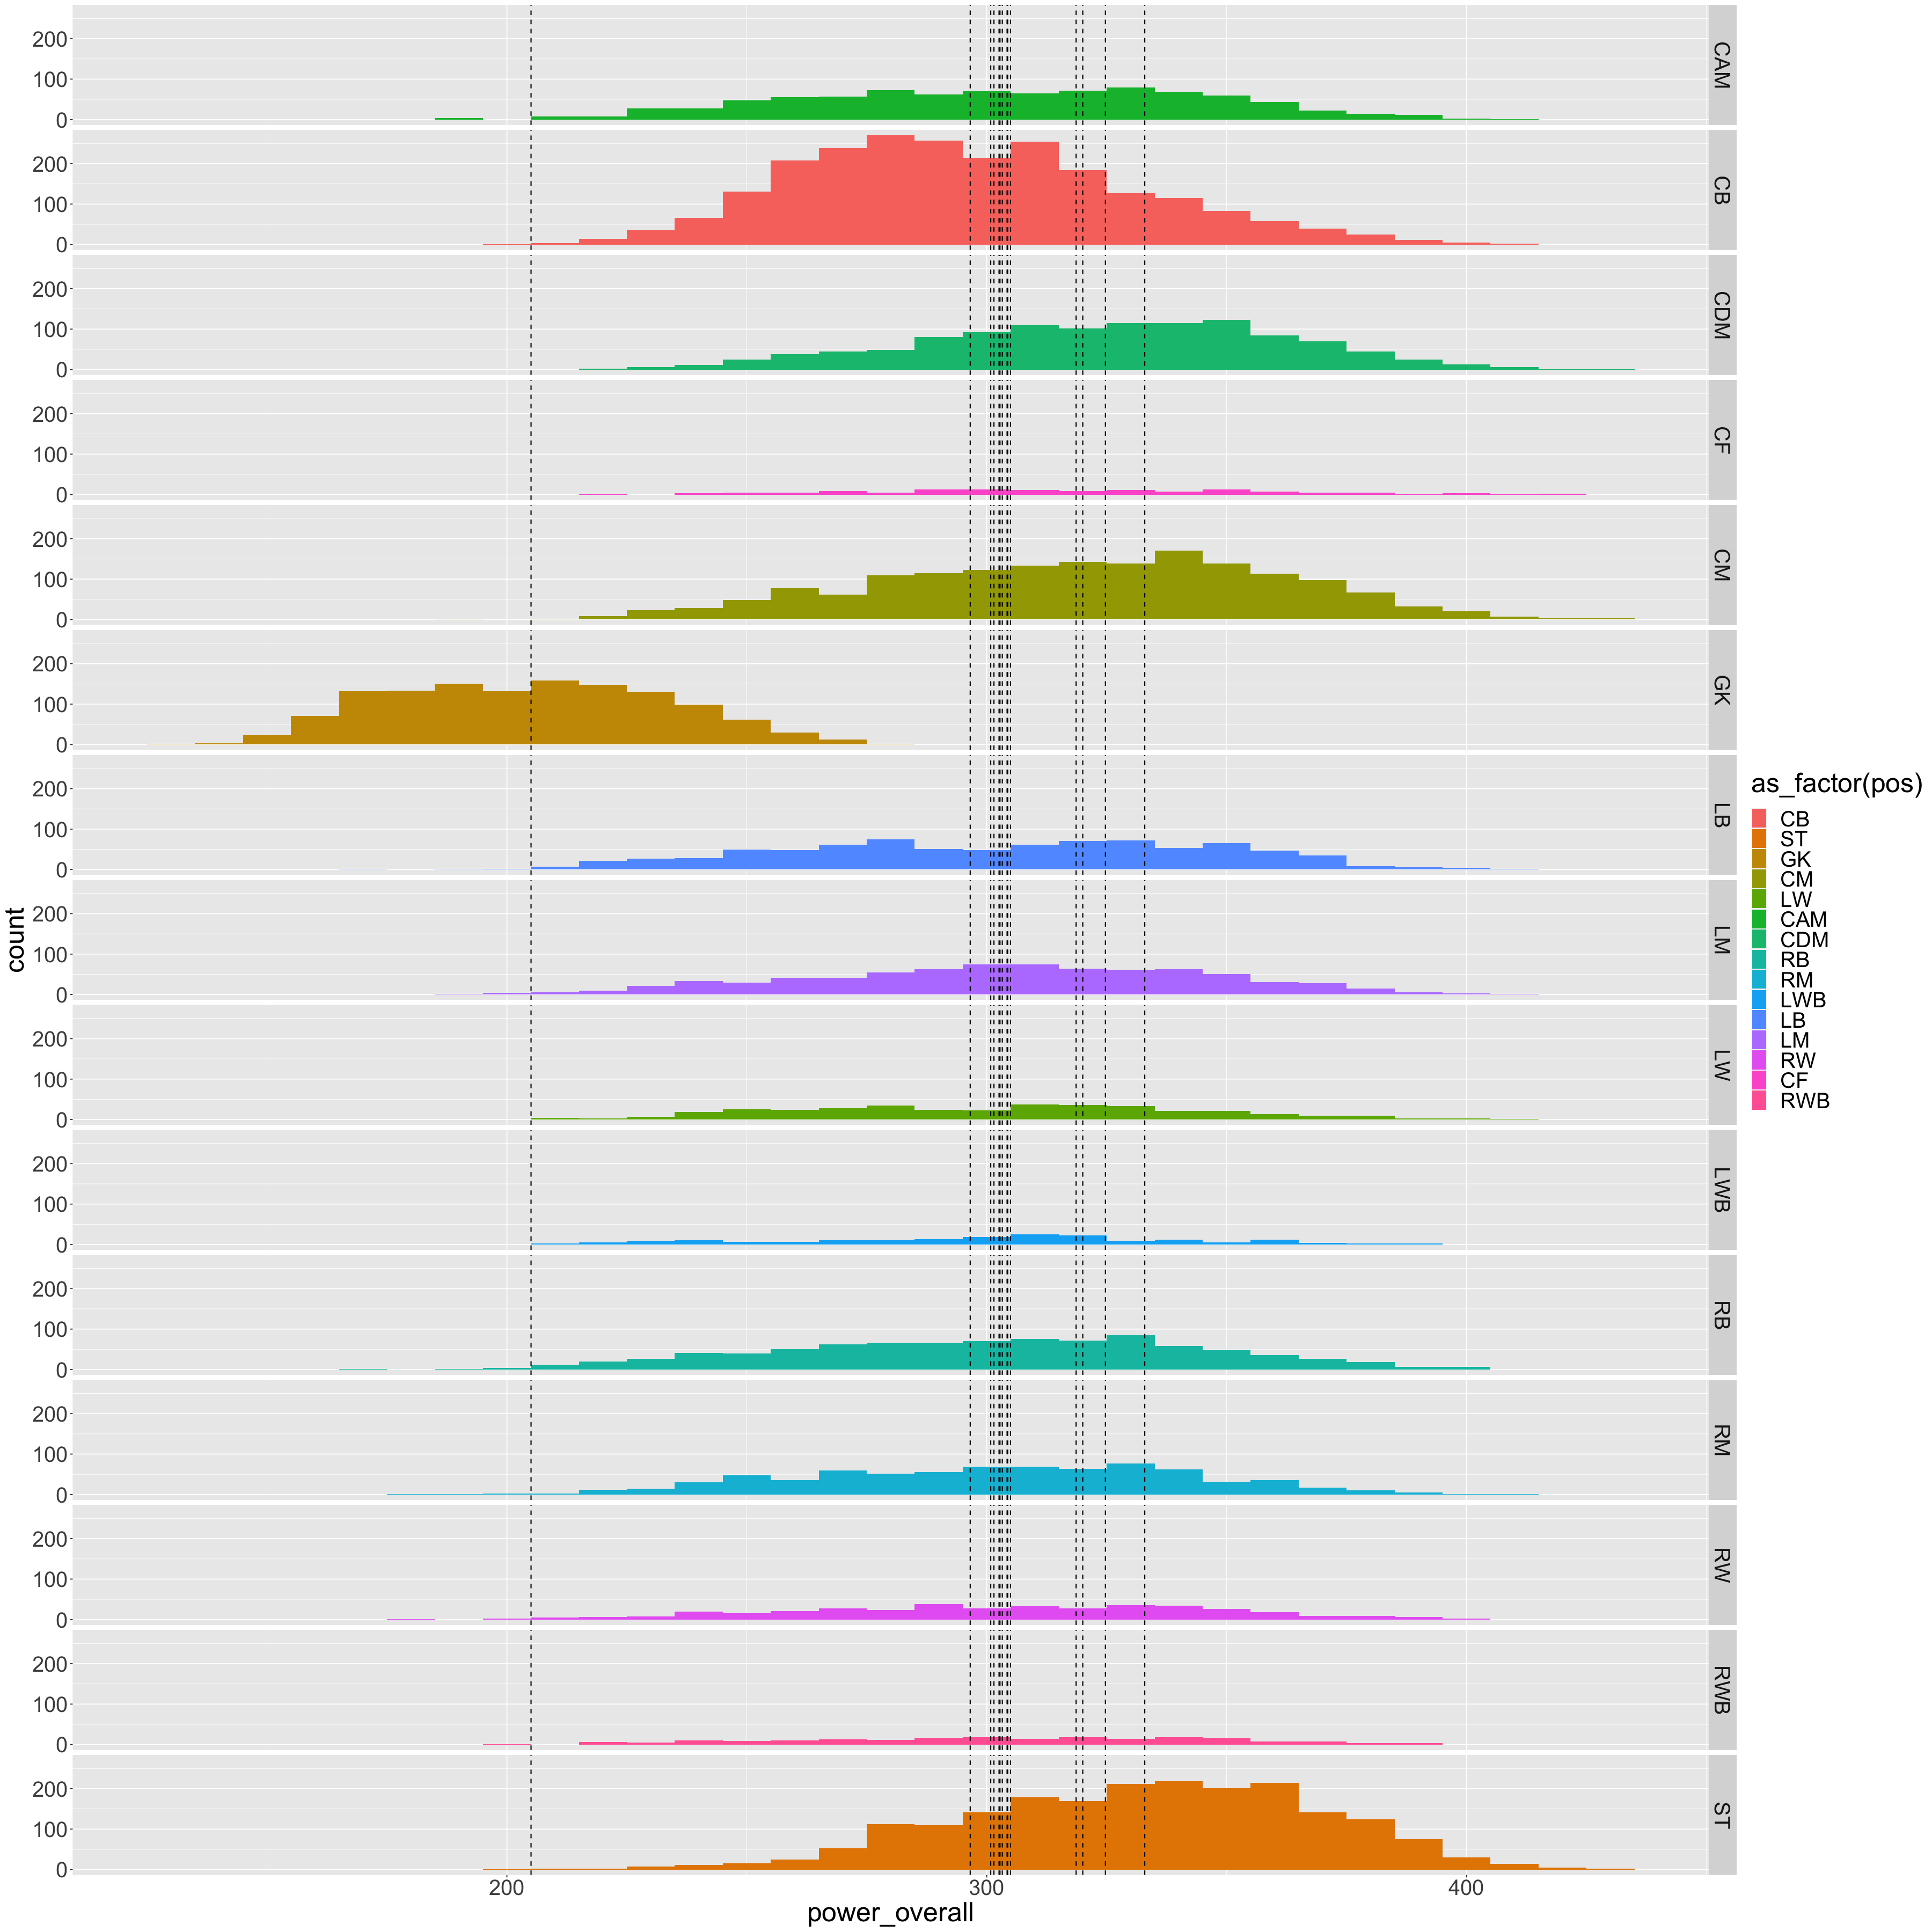

In [282]:
power_mean_by_pos <-power %>%
group_by(pos) %>%
summarise(power_mean_pos = mean(power_overall))%>%
pull(power_mean_pos)

power_mean_by_pos_ordered <- power %>%
group_by(pos) %>%
summarise(power_mean_pos = mean(power_overall))%>%
arrange(desc(power_mean_pos))
power_mean_by_pos_ordered

power_pos_plot <- power %>%
select(pos, power_overall) %>%
ggplot(aes(x = power_overall, fill = as_factor(pos)))+
geom_histogram(binwidth = 10)+
facet_grid(rows = vars(pos))+
theme(text = element_text(size = 30))+
geom_vline(xintercept = power_mean_by_pos, linetype = "dashed", size = 0.6)
power_pos_plot
#ggsave("power_pos_plot.jpg", power_pos_plot)

## 7.5 MENTALITY

In [261]:
m1 <- 1 #TBA
m2 <- 1 #TBA
m3 <- 1 #TBA
m4 <- 1 #TBA
m5 <- 1 #TBA
m6 <- 1 #TBA
mentality <- raw%>%
select(pos, aggression,
interceptions,
positioning,
vision,
penalties,
composure) %>%
mutate(mentality_overall = m1*aggression+
m2*interceptions+
m3*positioning+
m4*vision+
m5*penalties+
m6*composure)
head(mentality)

pos aggression interceptions positioning vision penalties composure
1 CB  63         60            14          52     61        61       
2 ST  77         42             7          68     74        76       
3 GK  27         17            73          49     17        47       
4 GK  34         16            72          51     20        64       
5 GK  25         17            71          53     25        65       
6 ST  68         21            16          60     79        59       
  mentality_overall
1 311              
2 344              
3 230              
4 257              
5 256              
6 303

pos mentality_mean_pos
1  CDM 322.2114          
2  CM  318.0415          
3  CAM 294.4971          
4  LB  293.7160          
5  RB  292.9127          
6  RWB 292.4221          
7  LWB 291.8413          
8  CF  291.1475          
9  CB  286.6926          
10 LM  276.9120          
11 RM  276.7881          
12 RW  274.3098          
13 ST  273.3694          
14 LW  271.0868          
15 GK  205.4798

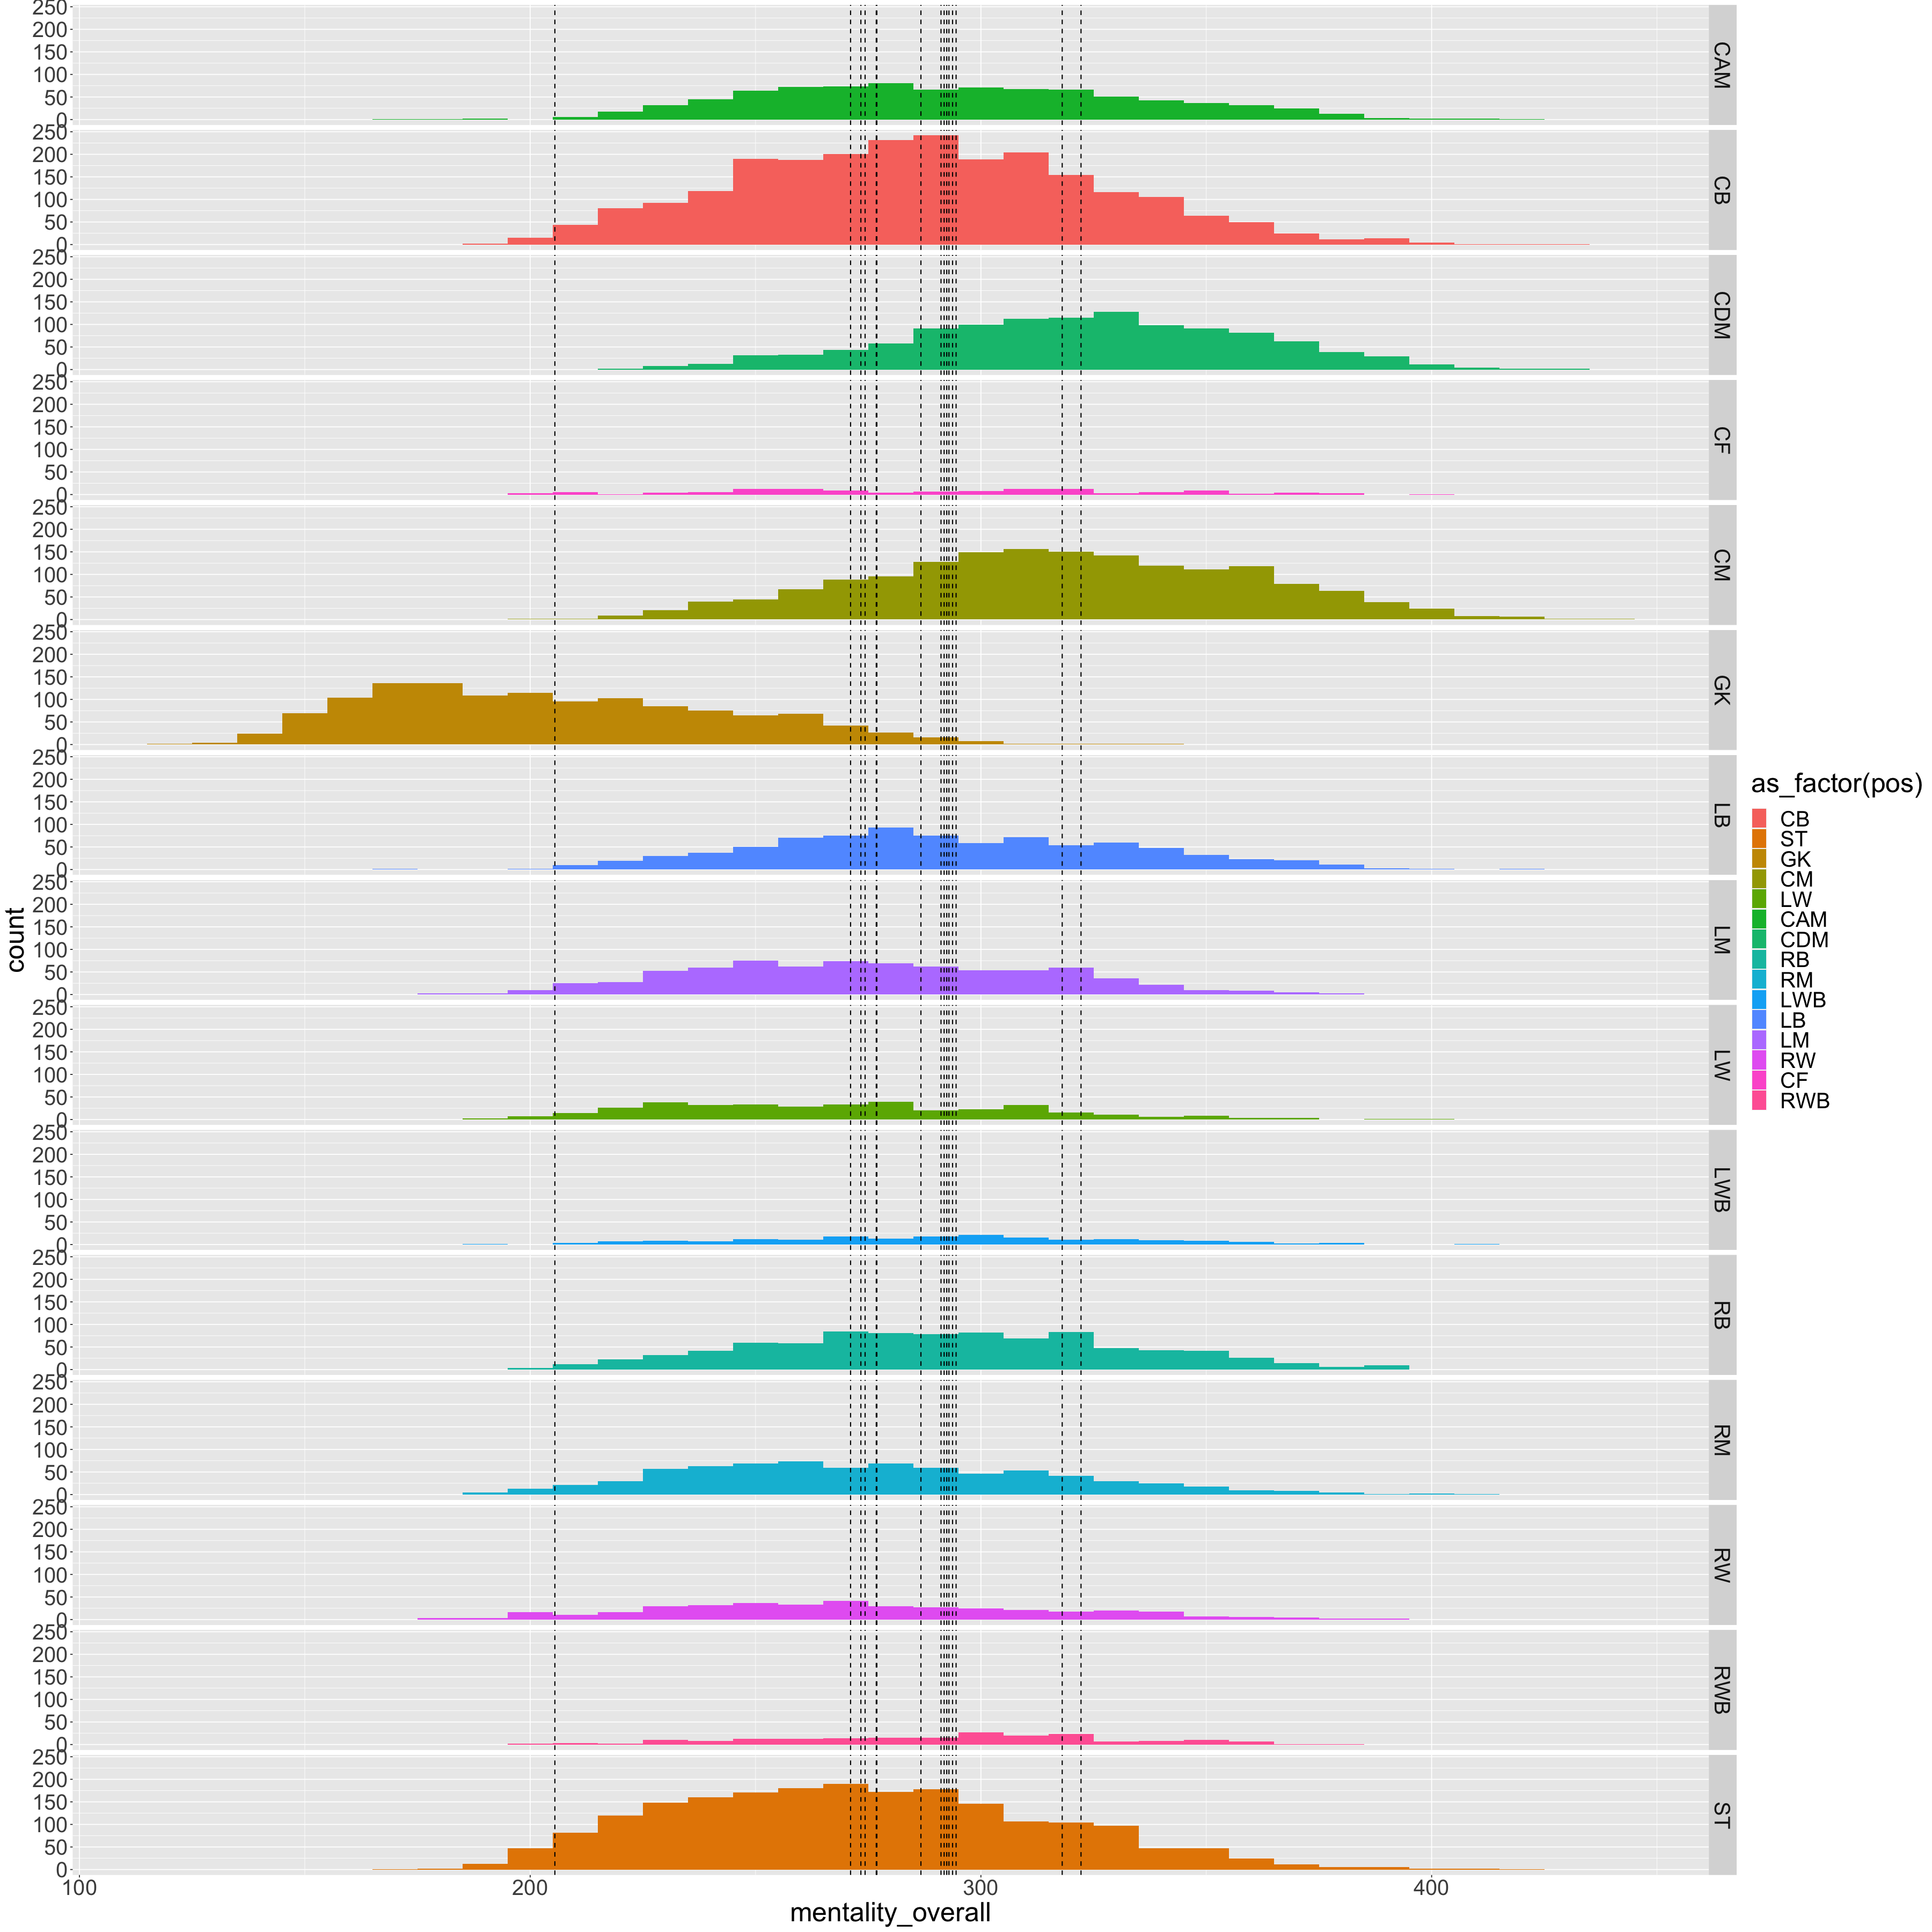

In [285]:
mentality_mean_by_pos <-mentality %>%
group_by(pos) %>%
summarise(mentality_mean_pos = mean(mentality_overall))%>%
pull(mentality_mean_pos)

mentality_mean_by_pos_ordered <- mentality %>%
group_by(pos) %>%
summarise(mentality_mean_pos = mean(mentality_overall))%>%
arrange(desc(mentality_mean_pos))
mentality_mean_by_pos_ordered


mentality_pos_plot <- mentality %>%
select(pos, mentality_overall) %>%
ggplot(aes(x = mentality_overall, fill = as_factor(pos)))+
geom_histogram(binwidth = 10)+
facet_grid(rows = vars(pos))+
theme(text = element_text(size = 30))+
geom_vline(xintercept = mentality_mean_by_pos, linetype = "dashed", size = 0.6)
mentality_pos_plot
#ggsave("mentality_pos_plot.jpg", mentality_pos_plot)

## 7.6 Defending

In [288]:
d1 <- 1 #TBA
d2 <- 1 #TBA
d3 <- 1 #TBA


defending <- raw%>%
select(pos, defensive_awareness,
standing_tackle,
sliding_tackle) %>%
mutate(defending_overall = d1*defensive_awareness+
d2*standing_tackle+
d3*sliding_tackle)
head(defending)

pos defensive_awareness standing_tackle sliding_tackle defending_overall
1 CB  59                  61              59             179              
2 ST  37                  39              34             110              
3 GK  22                  14              13              49              
4 GK  19                  16              14              49              
5 GK  12                  22              17              51              
6 ST  14                  36              34              84

pos defending_mean_pos
1  CB  200.25235         
2  CDM 195.61525         
3  RB  190.49944         
4  LB  189.83787         
5  RWB 188.85930         
6  LWB 185.37566         
7  CM  176.79087         
8  CAM 126.44903         
9  RM  116.16556         
10 LM  114.31048         
11 RW  104.23929         
12 CF  102.50000         
13 LW   99.89737         
14 ST   77.75327         
15 GK   40.20186

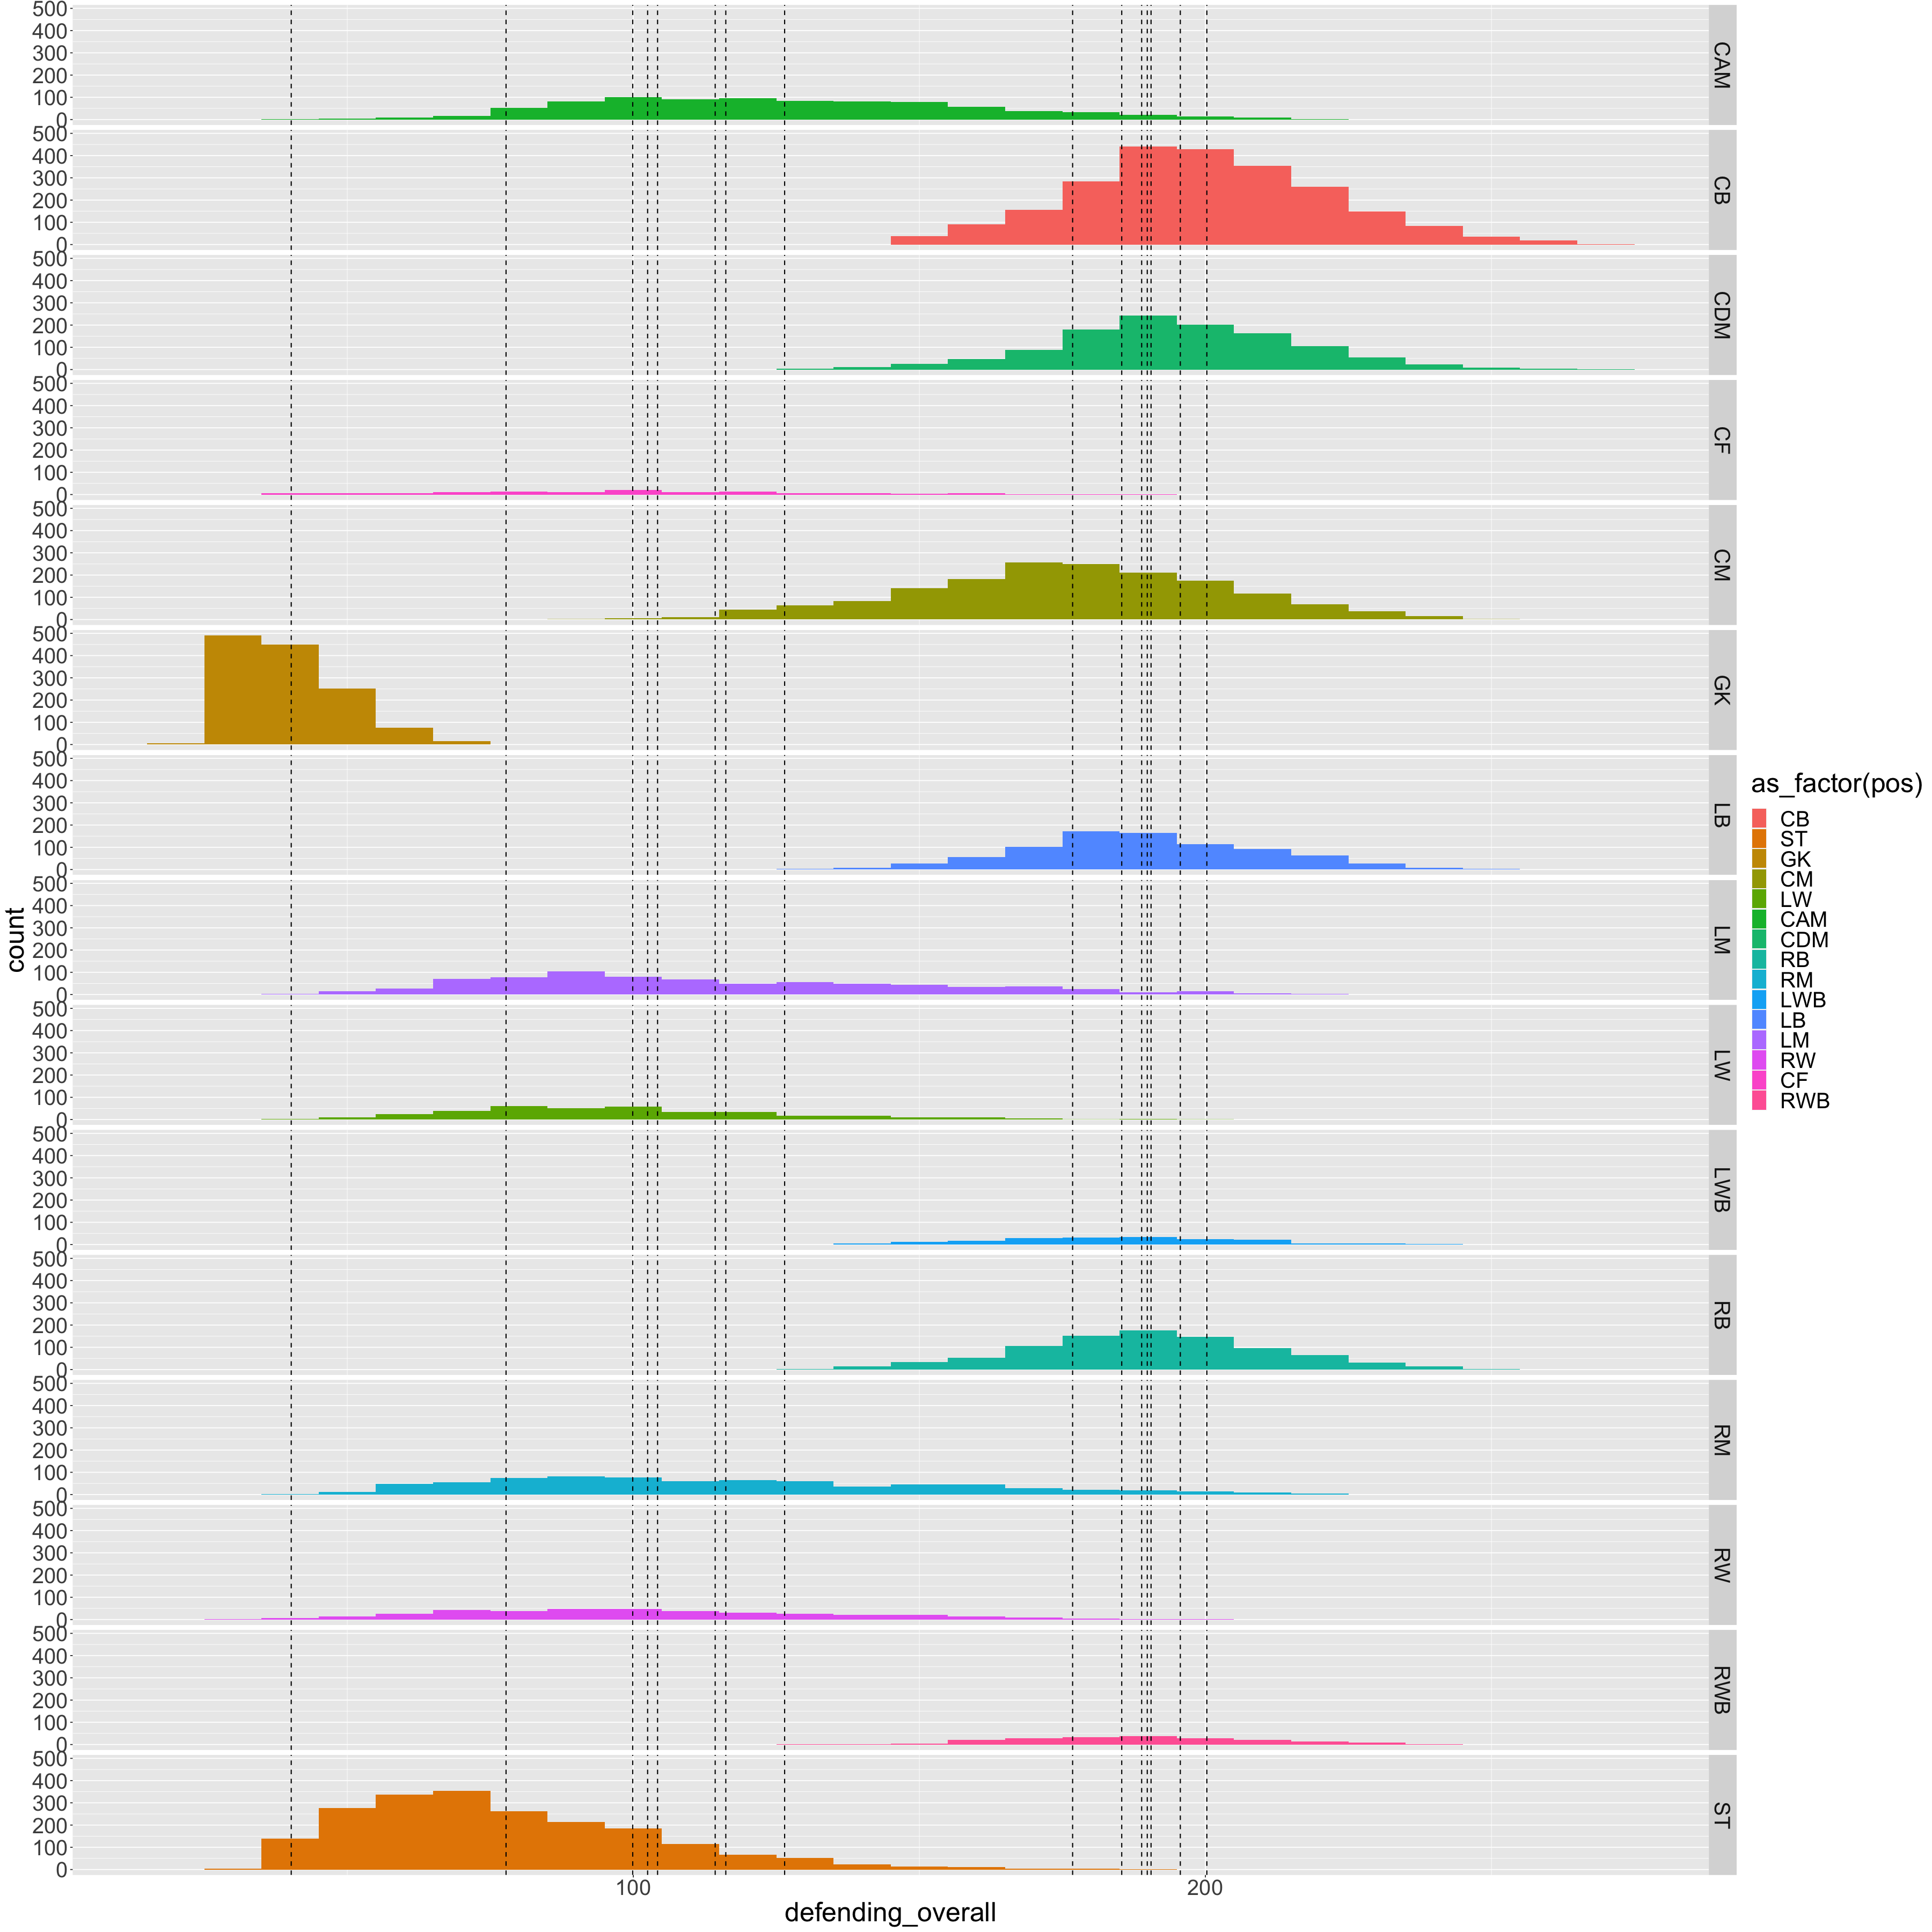

In [289]:
defending_mean_by_pos <-defending %>%
group_by(pos) %>%
summarise(defending_mean_pos = mean(defending_overall))%>%
pull(defending_mean_pos)

defending_mean_by_pos_ordered <- defending %>%
group_by(pos) %>%
summarise(defending_mean_pos = mean(defending_overall))%>%
arrange(desc(defending_mean_pos))
defending_mean_by_pos_ordered


defending_pos_plot <- defending %>%
select(pos, defending_overall) %>%
ggplot(aes(x = defending_overall, fill = as_factor(pos)))+
geom_histogram(binwidth = 10)+
facet_grid(rows = vars(pos))+
theme(text = element_text(size = 30))+
geom_vline(xintercept = defending_mean_by_pos, linetype = "dashed", size = 0.6)
defending_pos_plot
#ggsave("mentality_pos_plot.jpg", mentality_pos_plot)